In [1]:
# Imports
import os, sys, types
import pathlib
from importlib import reload
import pickle
import copy

import numpy as np
import scipy
from matplotlib import pyplot as plt
import qiskit.quantum_info as qi
import h5py

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import IBMQ, BasicAer, Aer, transpile, assemble, execute

In [3]:
from qiskit.providers.aer import AerSimulator

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector, DensityMatrix

from qiskit.opflow import (PauliOp, SummedOp, PauliExpectation, PauliSumOp,
    OperatorBase,
    ExpectationBase,
    ExpectationFactory,
    StateFn,
    CircuitStateFn,
    ListOp,
    CircuitSampler,
)

In [5]:
# PySCFDriver is no longer a thing
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper

from qiskit_nature.circuit.library import HartreeFock, UCCSD, UCC
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import L_BFGS_B, COBYLA, SPSA
from qiskit.algorithms import  MinimumEigensolver, VQE, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import TwoLocal, ExcitationPreserving

In [6]:
# Extra things for getting the Pauli decomposition quickly
from pyscf import ao2mo

from qiskit_nature.properties.second_quantization.electronic import (
    ElectronicEnergy,
    ElectronicDipoleMoment,
    ParticleNumber,
    AngularMomentum,
    Magnetization,
)

from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis

/Users/arkopal/miniconda3/envs/qbe-qiskit/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [7]:
# Local package imports
# Update this with setup & develop later
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [8]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

In [9]:
import qbe

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.22.1', 'qiskit-aer': '0.11.1', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.1', 'qiskit-nature': '0.4.4', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

# 0. Pauli Decomposition of H4 Fragments

In [12]:
%env HDF5_USE_FILE_LOCKING = FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [13]:
# Whether to read in MO or AO integrals. 0 for AO, 1 for MO. For local information used in the matching, we should set read_ints_basis = 0 to use AO basis.
# Here "AO" is defined as the initial basis where bootstrap embedding Hamiltonians are obtained. While "MO" is defined as the new orbitals defined by the HF solutions of the BE hamiltonians.
read_ints_basis = 0

## This is the fragment Hamiltonian
mol_name = 'H4_pert_'
# mol_name = 'H8_pert_'
num_frag = 2  # number of fragments
nao = 4  # nao - no. of orbs

DATA_DIR = '../data/' 
num_it = 1

# Datastructure of Pauli decomposition 
pd_fragments_H4_init = {}

with open(DATA_DIR + mol_name + 'initial_ham_pauli.txt', 'w') as file_ham_pauli:
    for it in range(num_it):
        for frag in range(num_frag):
            index1e = 'i' + str(it) + 'f' + str(frag)
            index2e = 'f' + str(frag)
            print('***' + index1e + '***')
            file_ham_pauli.write('***' + index1e + '***\n')

            # access 1e- integral
            if read_ints_basis == 0:
                r = h5py.File(DATA_DIR + mol_name + 'h1.h5', 'r')
            else:
                r = h5py.File(DATA_DIR + mol_name + 'h1_mo.h5', 'r')
            h1 = np.array(r.get(index1e))
            # print(h1)
            r.close()

            # access 2e- integral
            if read_ints_basis == 0:
                r = h5py.File(DATA_DIR + mol_name + 'eri_file.h5', 'r')
            else:
                r = h5py.File(DATA_DIR + mol_name + 'eri_mo_file.h5', 'r')

            # r.keys()
            h2 = np.array(r.get(index2e))
            r.close()
            # print(h2)

            ## Change from 4-fold to no symmetry
            symm = 1  # change to 1 for no symmetry
            # print(h2)
            eri = ao2mo.restore(symm, h2, nao)

            ## Try to get rid of last spatial orbital
            # nao=5
            # h1 = h1[:-1, :-1]
            # eri = eri[:-1, :-1, :-1, :-1]

            electronic_energy_from_ints = ElectronicEnergy.from_raw_integrals(
                ElectronicBasis.MO, h1, eri.reshape((nao, nao, nao, nao))
            )
            # print(electronic_energy_from_ints)

            ferOp = electronic_energy_from_ints.second_q_ops()[0]  # here, output length is always 1
            # es_problem = ElectronicStructureProblem(electronic_energy_from_ints)
            qubit_converter = QubitConverter(mapper=JordanWignerMapper())
            # qubit_converter = QubitConverter(mapper = ParityMapper(), two_qubit_reduction = True)
            qubitOp = qubit_converter.convert(ferOp)  # this will not give two-qubit reduction
            # qubitOp = qubit_converter.convert(ferOp, nao) # use this and the above to get two-qubit reduction
            print(qubitOp[0])
            print('number of total qubits: %d \n' % qubitOp.num_qubits)

            file_ham_pauli.write("%s\n\n" % qubitOp)
            
            # Update the datastructure
            pd_fragments_H4_init.update({str(frag): qubitOp})
            
    print('Done')

***i0f0***


/var/folders/z7/960_kj0n3fg8pz04mn8cyp_40000gn/T/ipykernel_6132/811962643.py:60: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  ferOp = electronic_energy_from_ints.second_q_ops()[0]  # here, output length is always 1


-1.6245790607368034 * IIIIIIII
number of total qubits: 8 

***i0f1***
-3.124579060736799 * IIIIIIII
number of total qubits: 8 

Done


In [14]:
qubitop_H4_frag0 = pd_fragments_H4_init['0']

In [15]:
qubitop_H4_frag0

PauliSumOp(SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIIYY', 'IIIIIIXX', 'IIIIIYZY', 'IIIIIXZX', 'IIIIYZZY', 'IIIIXZZX', 'IIIIIIZI', 'IIIIIYYI', 'IIIIIXXI', 'IIIIYZYI', 'IIIIXZXI', 'IIIIIZII', 'IIIIYYII', 'IIIIXXII', 'IIIIZIII', 'IIIZIIII', 'IIYYIIII', 'IIXXIIII', 'IYZYIIII', 'IXZXIIII', 'YZZYIIII', 'XZZXIIII', 'IIZIIIII', 'IYYIIIII', 'IXXIIIII', 'YZYIIIII', 'XZXIIIII', 'IZIIIIII', 'YYIIIIII', 'XXIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIYYZ', 'IIIIIXXZ', 'IIIIYZYZ', 'IIIIXZXZ', 'IIIIIZIZ', 'IIIIYYIZ', 'IIIIXXIZ', 'IIIIZIIZ', 'IIIIIYIY', 'IIIIIXIX', 'IIIIYZIY', 'IIIIXZIX', 'IIIIIZYY', 'IIIIIZXX', 'IIIIYXXY', 'IIIIYYYY', 'IIIIXXYY', 'IIIIYYXX', 'IIIIXXXX', 'IIIIXYYX', 'IIIIZIYY', 'IIIIZIXX', 'IIIIYIZY', 'IIIIXIZX', 'IIIIZYZY', 'IIIIZXZX', 'IIIZIIIZ', 'IIIZIIYY', 'IIIZIIXX', 'IIIZIYZY', 'IIIZIXZX', 'IIIZYZZY', 'IIIZXZZX', 'IIYYIIIZ', 'IIXXIIIZ', 'IIYYIIYY', 'IIXXIIYY', 'IIYYIIXX', 'IIXXIIXX', 'IIYYIYZY', 'IIXXIYZY', 'IIYYIXZX', 'IIXXIXZX', 'IIYYYZZY', 'IIXXYZZY', 'IIYYXZZX', 'IIXXXZZX', 'I

In [16]:
# qubitop_H4_frag0.add(PauliOp(Pauli('I'*7+'Z'),0.12))

In [17]:
dict_H = {}
_temp_ham = qubitop_H4_frag0.to_pauli_op()

for ind in range(len(_temp_ham)):
    # x is a PauliOp
    x = _temp_ham[ind]
    dict_H.update({str(x.primitive): x.coeff})

In [18]:
dict_H

{'IIIIIIII': -1.6245790607368034,
 'IIIIIIIZ': -0.010704363719251424,
 'IIIIIIYY': -0.1511396251696576,
 'IIIIIIXX': -0.1511396251696576,
 'IIIIIYZY': 0.03279747411873879,
 'IIIIIXZX': 0.03279747411873879,
 'IIIIYZZY': -0.007281988930088698,
 'IIIIXZZX': -0.007281988930088698,
 'IIIIIIZI': -0.06147809851727821,
 'IIIIIYYI': -0.16722123233510727,
 'IIIIIXXI': -0.16722123233510727,
 'IIIIYZYI': 0.0327974741187386,
 'IIIIXZXI': 0.0327974741187386,
 'IIIIIZII': -0.5614780985172778,
 'IIIIYYII': -0.1511396251696571,
 'IIIIXXII': -0.1511396251696571,
 'IIIIZIII': -0.010704363719251167,
 'IIIZIIII': -0.010704363719251495,
 'IIYYIIII': -0.1511396251696576,
 'IIXXIIII': -0.1511396251696576,
 'IYZYIIII': 0.03279747411873879,
 'IXZXIIII': 0.03279747411873879,
 'YZZYIIII': -0.007281988930088696,
 'XZZXIIII': -0.007281988930088696,
 'IIZIIIII': -0.0614780985172783,
 'IYYIIIII': -0.16722123233510727,
 'IXXIIIII': -0.16722123233510727,
 'YZYIIIII': 0.0327974741187386,
 'XZXIIIII': 0.0327974741187386,

In [19]:
ps = PauliSumOp.from_list(list([[P, dict_H[P]] for P in dict_H]))

In [20]:
ps

PauliSumOp(SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIIYY', 'IIIIIIXX', 'IIIIIYZY', 'IIIIIXZX', 'IIIIYZZY', 'IIIIXZZX', 'IIIIIIZI', 'IIIIIYYI', 'IIIIIXXI', 'IIIIYZYI', 'IIIIXZXI', 'IIIIIZII', 'IIIIYYII', 'IIIIXXII', 'IIIIZIII', 'IIIZIIII', 'IIYYIIII', 'IIXXIIII', 'IYZYIIII', 'IXZXIIII', 'YZZYIIII', 'XZZXIIII', 'IIZIIIII', 'IYYIIIII', 'IXXIIIII', 'YZYIIIII', 'XZXIIIII', 'IZIIIIII', 'YYIIIIII', 'XXIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIYYZ', 'IIIIIXXZ', 'IIIIYZYZ', 'IIIIXZXZ', 'IIIIIZIZ', 'IIIIYYIZ', 'IIIIXXIZ', 'IIIIZIIZ', 'IIIIIYIY', 'IIIIIXIX', 'IIIIYZIY', 'IIIIXZIX', 'IIIIIZYY', 'IIIIIZXX', 'IIIIYXXY', 'IIIIYYYY', 'IIIIXXYY', 'IIIIYYXX', 'IIIIXXXX', 'IIIIXYYX', 'IIIIZIYY', 'IIIIZIXX', 'IIIIYIZY', 'IIIIXIZX', 'IIIIZYZY', 'IIIIZXZX', 'IIIZIIIZ', 'IIIZIIYY', 'IIIZIIXX', 'IIIZIYZY', 'IIIZIXZX', 'IIIZYZZY', 'IIIZXZZX', 'IIYYIIIZ', 'IIXXIIIZ', 'IIYYIIYY', 'IIXXIIYY', 'IIYYIIXX', 'IIXXIIXX', 'IIYYIYZY', 'IIXXIYZY', 'IIYYIXZX', 'IIXXIXZX', 'IIYYYZZY', 'IIXXYZZY', 'IIYYXZZX', 'IIXXXZZX', 'I

In [21]:
len(qubitop_H4_frag0)

361

In [22]:
qubitop_H4_frag0.num_qubits

8

In [23]:
# create target observables for each pauli decomposition
# that keeps track of Paulis in PauliSumOp

In [24]:
# Check how the addition of a new Pauli would work
ham_H4_frag0 = qubitop_H4_frag0.to_spmatrix()

In [25]:
S, V = scipy.sparse.linalg.eigsh(ham_H4_frag0)

ind = np.argmin(S)
gs_energy = S[ind]
gs_vec = V[:,ind]

In [26]:
print(gs_energy)

-3.8588128484366444


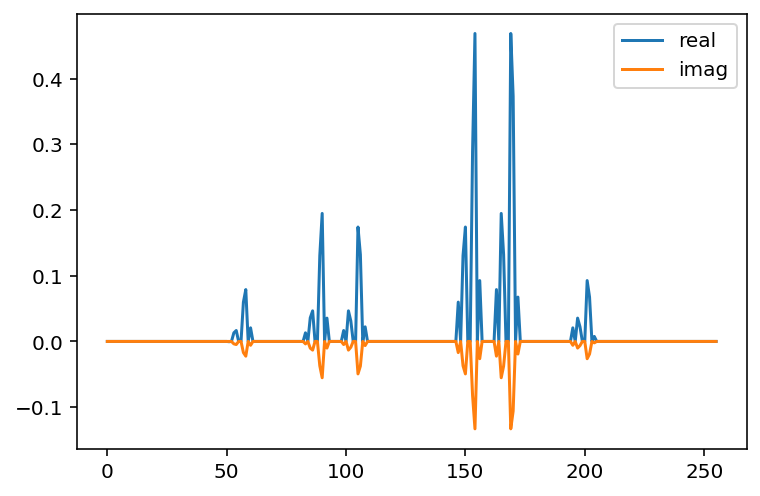

In [27]:
plt.plot(np.real(gs_vec), label='real')
plt.plot(np.imag(gs_vec), label='imag')
plt.legend(loc='best')
plt.show()

# 0. Comparison to H4 Fragment Hamiltonians

In [29]:
def init_fragment_hamiltonians(fragments,hamiltonian_data):
    '''
    initialize a dictionary where the keys are fragment labels 
    and the values are the corresponding fragment Hamiltonian matrices
    '''
    fragment_hamiltonians = {}
    for i in range(len(fragments)):
        fragment_hamiltonians[str(i)] = np.matrix(hamiltonian_data['i0f'+str(i)])
    return fragment_hamiltonians

In [30]:
# load the Hamiltonian matrices for each fragment
DATA_dir = '../data/'
hamiltonian_file = 'H4_initial_ham.h5'

hamiltonian_data = h5py.File(DATA_dir + hamiltonian_file, 'r')

In [31]:
# fragment info
n_frags = 2
n_qubits = 8

labels_fragments = ['0', '1']
fragment_info = {'0': [0,1,2,4,5,6],'1': [0,1,2,4,5,6]}
fragment_nb = {'0': {'1': {'n_sites': 2, 'edge': [(2,1),(6,5)], 'center': [(1,0),(5,4)]}}, 
                    '1': {'0': {'n_sites': 2, 'edge': [(0,1),(4,5)], 'center': [(1,2),(5,6)]}}}

In [32]:
fragment_H4_init = init_fragment_hamiltonians(fragment_info, hamiltonian_data)

In [33]:
# fragment_H4_init['0'] is the fragment that we care about
frag_H = scipy.sparse.csr_matrix(fragment_H4_init['0'])

# Let us get the classical stuff
# Classical solver
#gs_energy, gs_vec = qbe.fragment_hamiltonian.get_ground_state(frag_H)
S2, V2 = scipy.sparse.linalg.eigsh(frag_H)

ind = np.argmin(S2)
gs_energy2 = S2[ind]
gs_vec2 = V2[:,ind]

In [34]:
print(gs_energy2)

-3.8588128484366777


In [35]:
print(gs_energy)

-3.8588128484366533


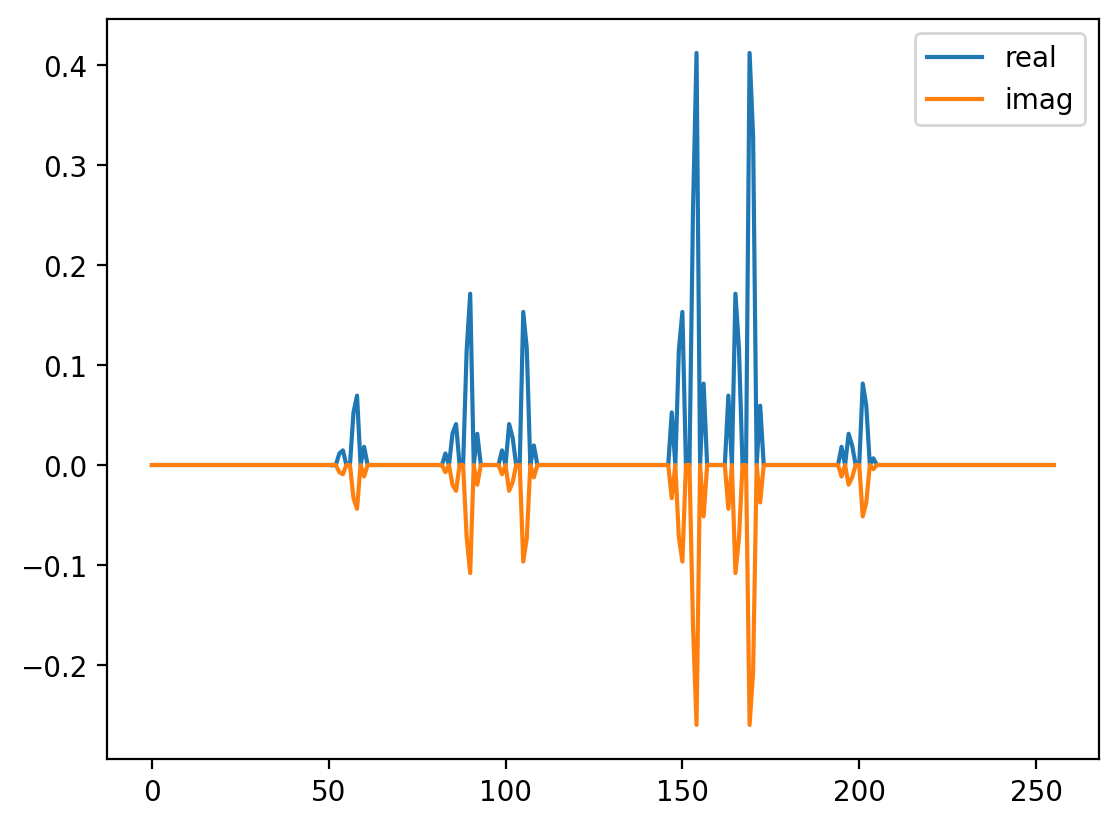

In [36]:
plt.plot(np.real(gs_vec2), label='real')
plt.plot(np.imag(gs_vec2), label='imag')
plt.legend(loc='best')
plt.show()

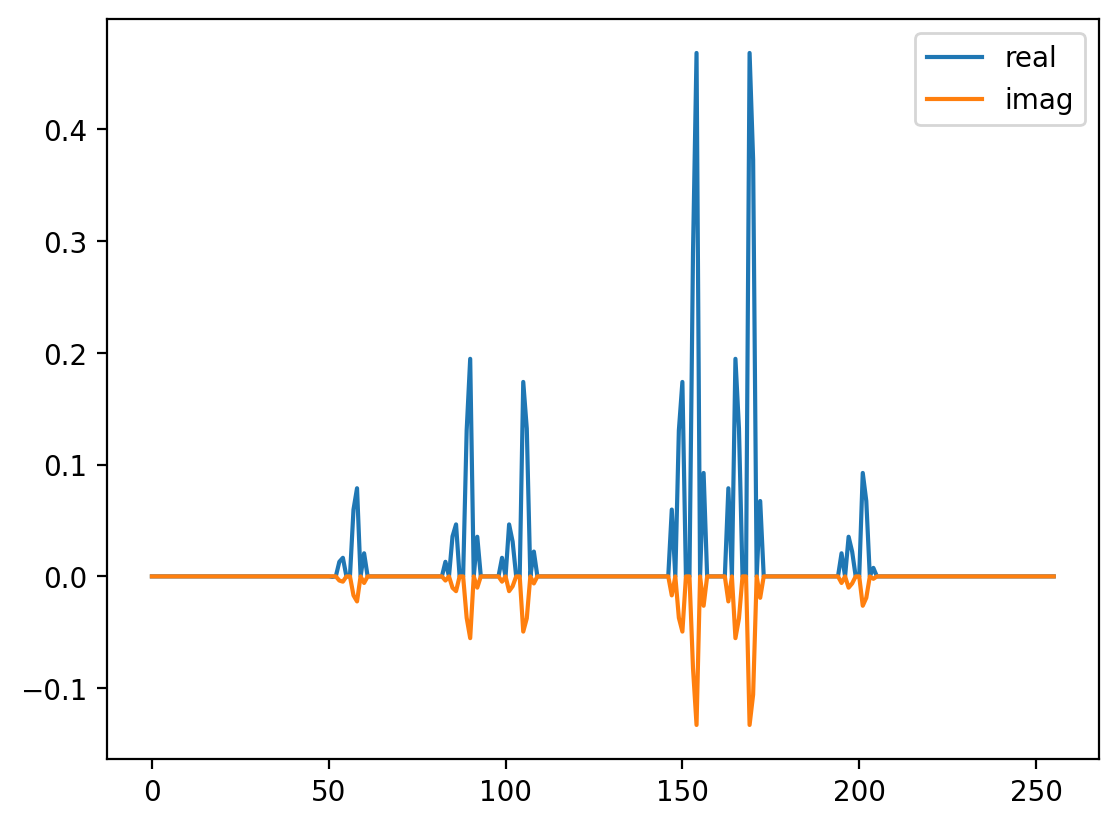

In [37]:
# b4 in comparison
plt.plot(np.real(gs_vec), label='real')
plt.plot(np.imag(gs_vec), label='imag')
plt.legend(loc='best')
plt.show()

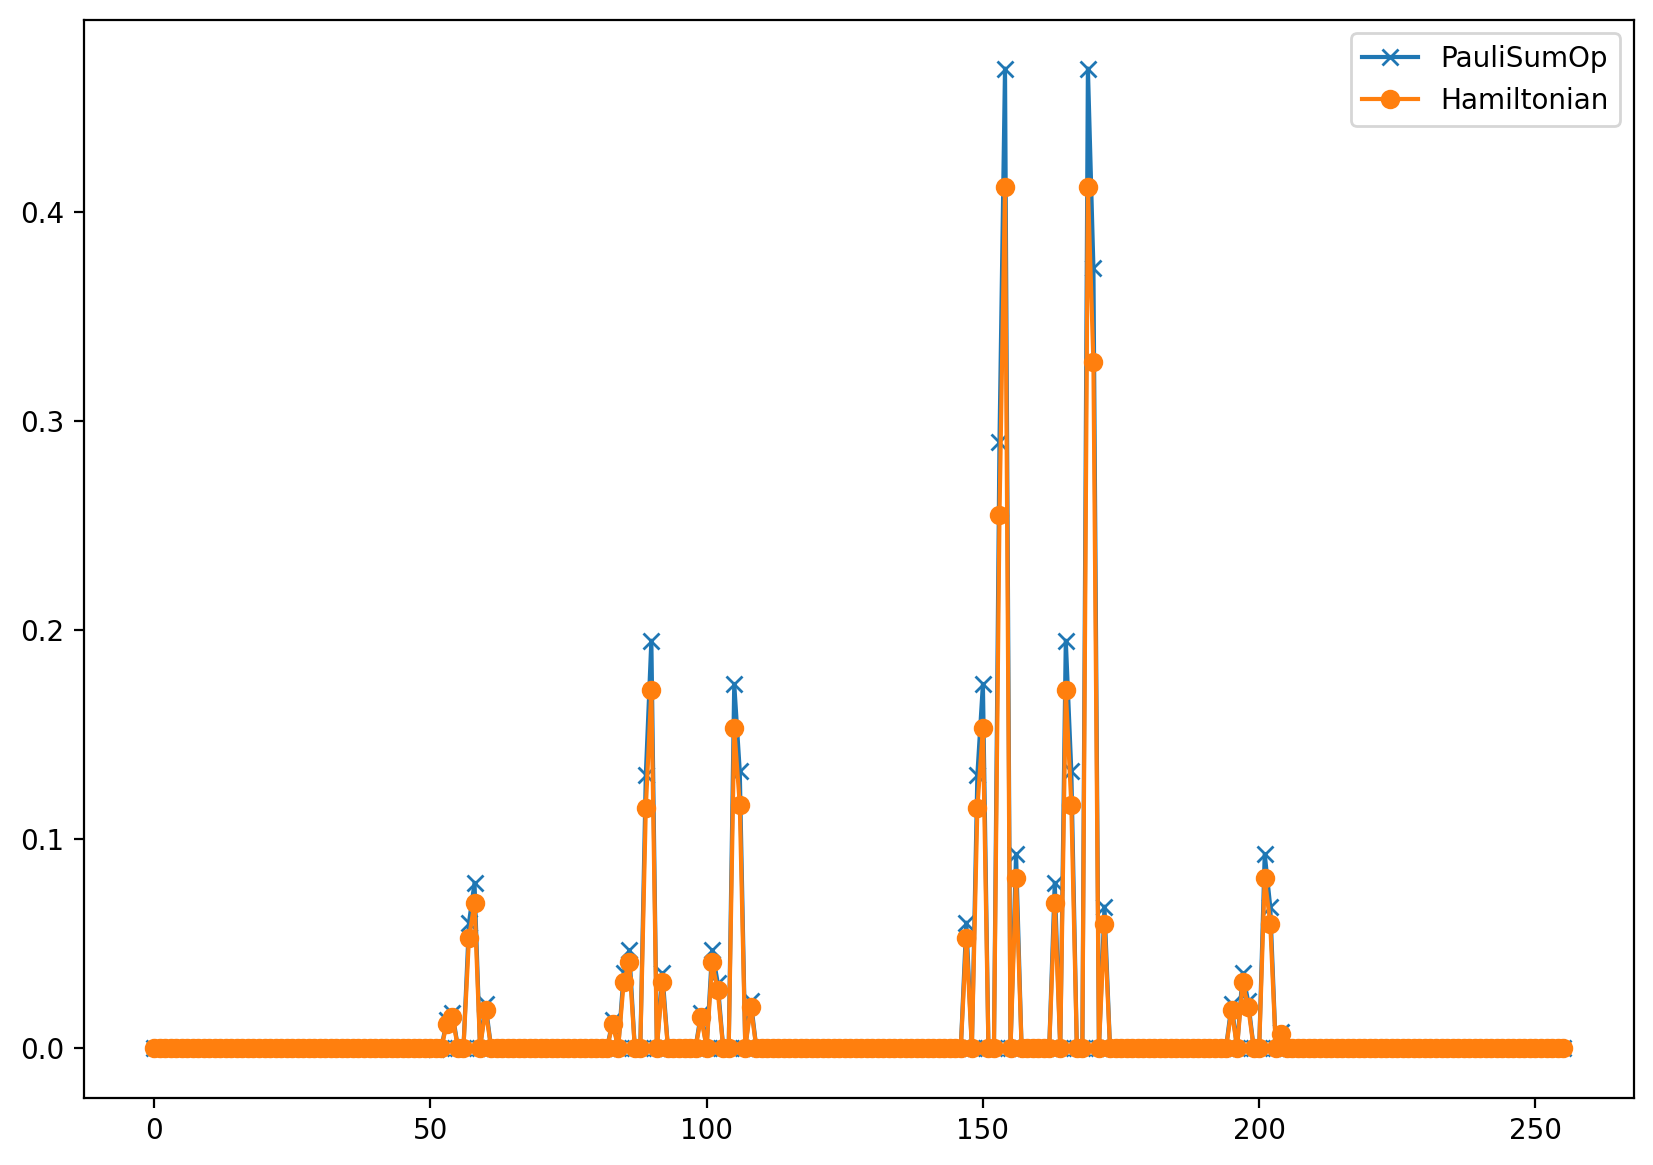

In [38]:
plt.figure(figsize=(10,7))
plt.plot(np.real(gs_vec), '-x', label='PauliSumOp')
plt.plot(np.real(gs_vec2), '-o', label='Hamiltonian')
plt.legend(loc='best')
plt.show()

## 1.1 VQE -- Single step of QBE-VQE with LO2MO

In [39]:
# Fetch the LO2MO
# U_lo2mo_H4 = qbe.utils.lo2mo_trans.get_unitary_lo2mo(file_name_1e='../data/H4_h1.h5', 
#                                                      file_name_2e='../data/H4_eri_file.h5', 
#                                                      num_ele=4)

U_lo2mo_H4 = qbe.utils.lo2mo_trans.get_unitary_lo2mo(file_name_1e='../data/H4_pert_h1.h5', 
                                                     file_name_2e='../data/H4_pert_eri_file.h5', 
                                                     num_ele=4)

Overwritten attributes  get_ovlp get_hcore  of <class 'pyscf.scf.hf.RHF'>


converged SCF energy = -3.82018676535482
Fermionic Operator
register length=8, number terms=33
  (0.1302718709462139+1.2933796330400554e-15j) * ( +_0 -_0 )
+ (-0.2266832842632044-0.6476248947407318j) * ( +_0 -_1 )
+ (-0.41707756847881594+0.432420938084343j) * ( +_0 -_2 )
+ (0.40859684639218 ...


In [40]:
U_lo2mo_H4

Instruction(name='hamiltonian', num_qubits=8, num_clbits=0, params=[array([[ 1.11022302e-16-8.87468518e-31j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -1.30271871e-01-1.29337963e-15j,
         2.26683284e-01+6.47624895e-01j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  2.26683284e-01-6.47624895e-01j,
        -3.94446714e-01-6.56537537e-16j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       ...,
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
        -5.88873859e+00-4.99528612e-15j,  2.26683284e-01+6.47624895e-01j,
         0.0000000

In [41]:
from qiskit.circuit import Gate

In [42]:
inv_U_lo2mo = U_lo2mo_H4.inverse()
inv_U_lo2mo.name = 'U_lo2mo_dag'

In [43]:
# Create ansatz -- with HF state
qubit_converter = QubitConverter(mapper=JordanWignerMapper())

num_alpha = 2
num_beta = 2
num_particles = (num_alpha, num_beta)

num_molecular_orbitals = 4
num_spin_orbitals = 2*num_molecular_orbitals

# Initial state -- hf_state composed with U_LO2MO^dagg
hf_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
hf_state.compose(inv_U_lo2mo, inplace=True)

In [44]:
hf_state.draw()

┌───┐┌──────────────┐
q_0: ┤ X ├┤0             ├
     ├───┤│              │
q_1: ┤ X ├┤1             ├
     └───┘│              │
q_2: ─────┤2             ├
          │              │
q_3: ─────┤3             ├
     ┌───┐│  U_lo2mo_dag │
q_4: ┤ X ├┤4             ├
     ├───┤│              │
q_5: ┤ X ├┤5             ├
     └───┘│              │
q_6: ─────┤6             ├
          │              │
q_7: ─────┤7             ├
          └──────────────┘

In [69]:
# Define ansatz
#ansatz = ExcitationPreserving(num_qubits=n_qubits, mode='fsim', entanglement='full', reps=3, 
#                              initial_state=hf_state)

#ansatz = ExcitationPreserving(num_qubits=n_qubits, mode='fsim', entanglement='full', reps=3)

ansatz = UCCSD(qubit_converter, num_particles, num_spin_orbitals, reps=1, initial_state=hf_state)
#ansatz = UCCSD(qubit_converter, num_particles, num_spin_orbitals, reps=1, initial_state=None)

# Define backend
backend = Aer.get_backend('statevector_simulator')

In [70]:
seed = 170
max_iters = 150
algorithm_globals.random_seed = seed

qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=10000)

counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    print(len(counts))


#opt_method = SPSA(maxiter=max_iters)
opt_method = L_BFGS_B(maxiter=150)
vqe = VQE(ansatz, opt_method, initial_point=None, 
          callback=store_intermediate_result, quantum_instance=qi)

result = vqe.compute_minimum_eigenvalue(operator=qubitop_H4_frag0)
#result.update({'opt_tracker': {'iters': counts, 'loss': values}})

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


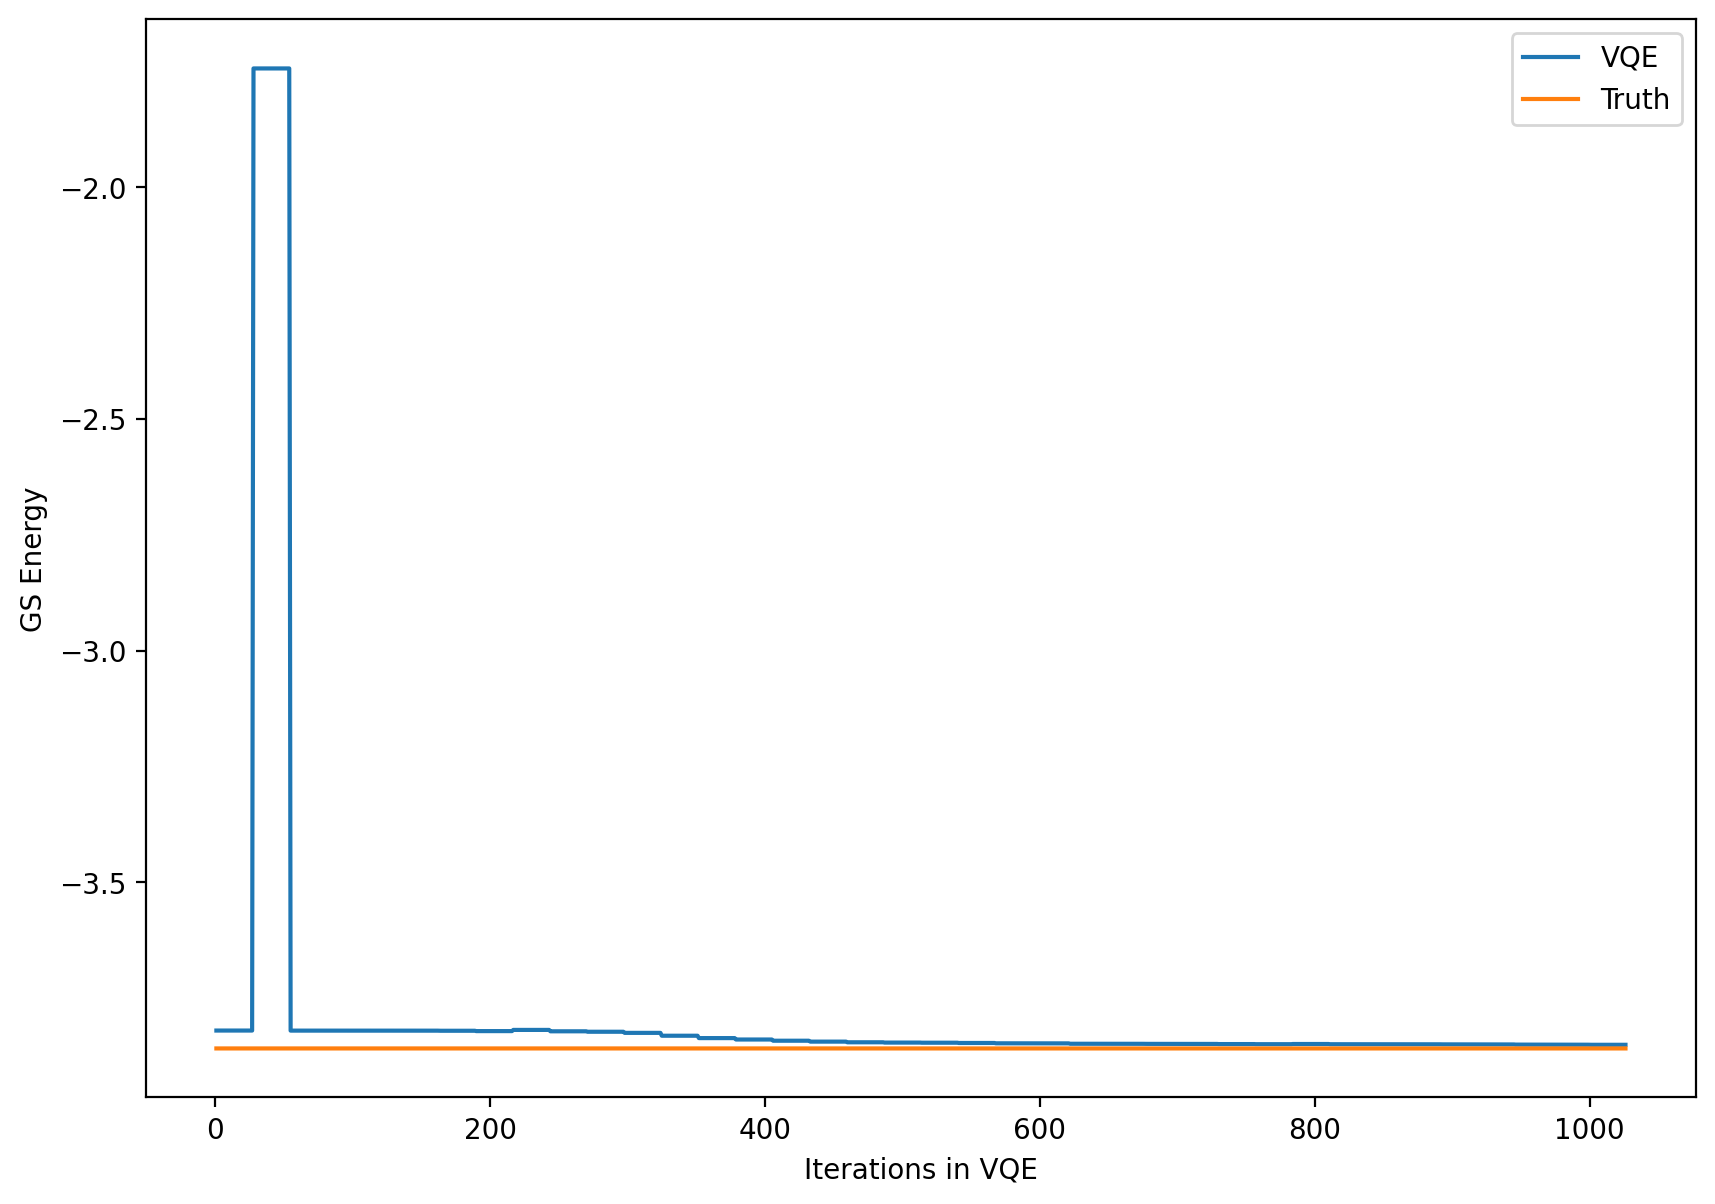

In [71]:
# Plot of gs energy vs iterations -- VQE with LO2MO
plt.figure(figsize=(10,7))
plt.plot(counts, values, label='VQE')
plt.plot(counts, gs_energy*np.ones(len(counts)), label='Truth')
plt.xlabel('Iterations in VQE')
plt.ylabel('GS Energy')
plt.legend(loc='best')

In [76]:
# r_E = |E_vqe - E_truth|/|E_truth|
ratio_energy = np.abs(values - gs_energy)/np.abs(gs_energy)

Text(0, 0.5, 'Relative error: $\\frac{|E_{vqe} - E_{truth}|}{|E_{truth}|}$')

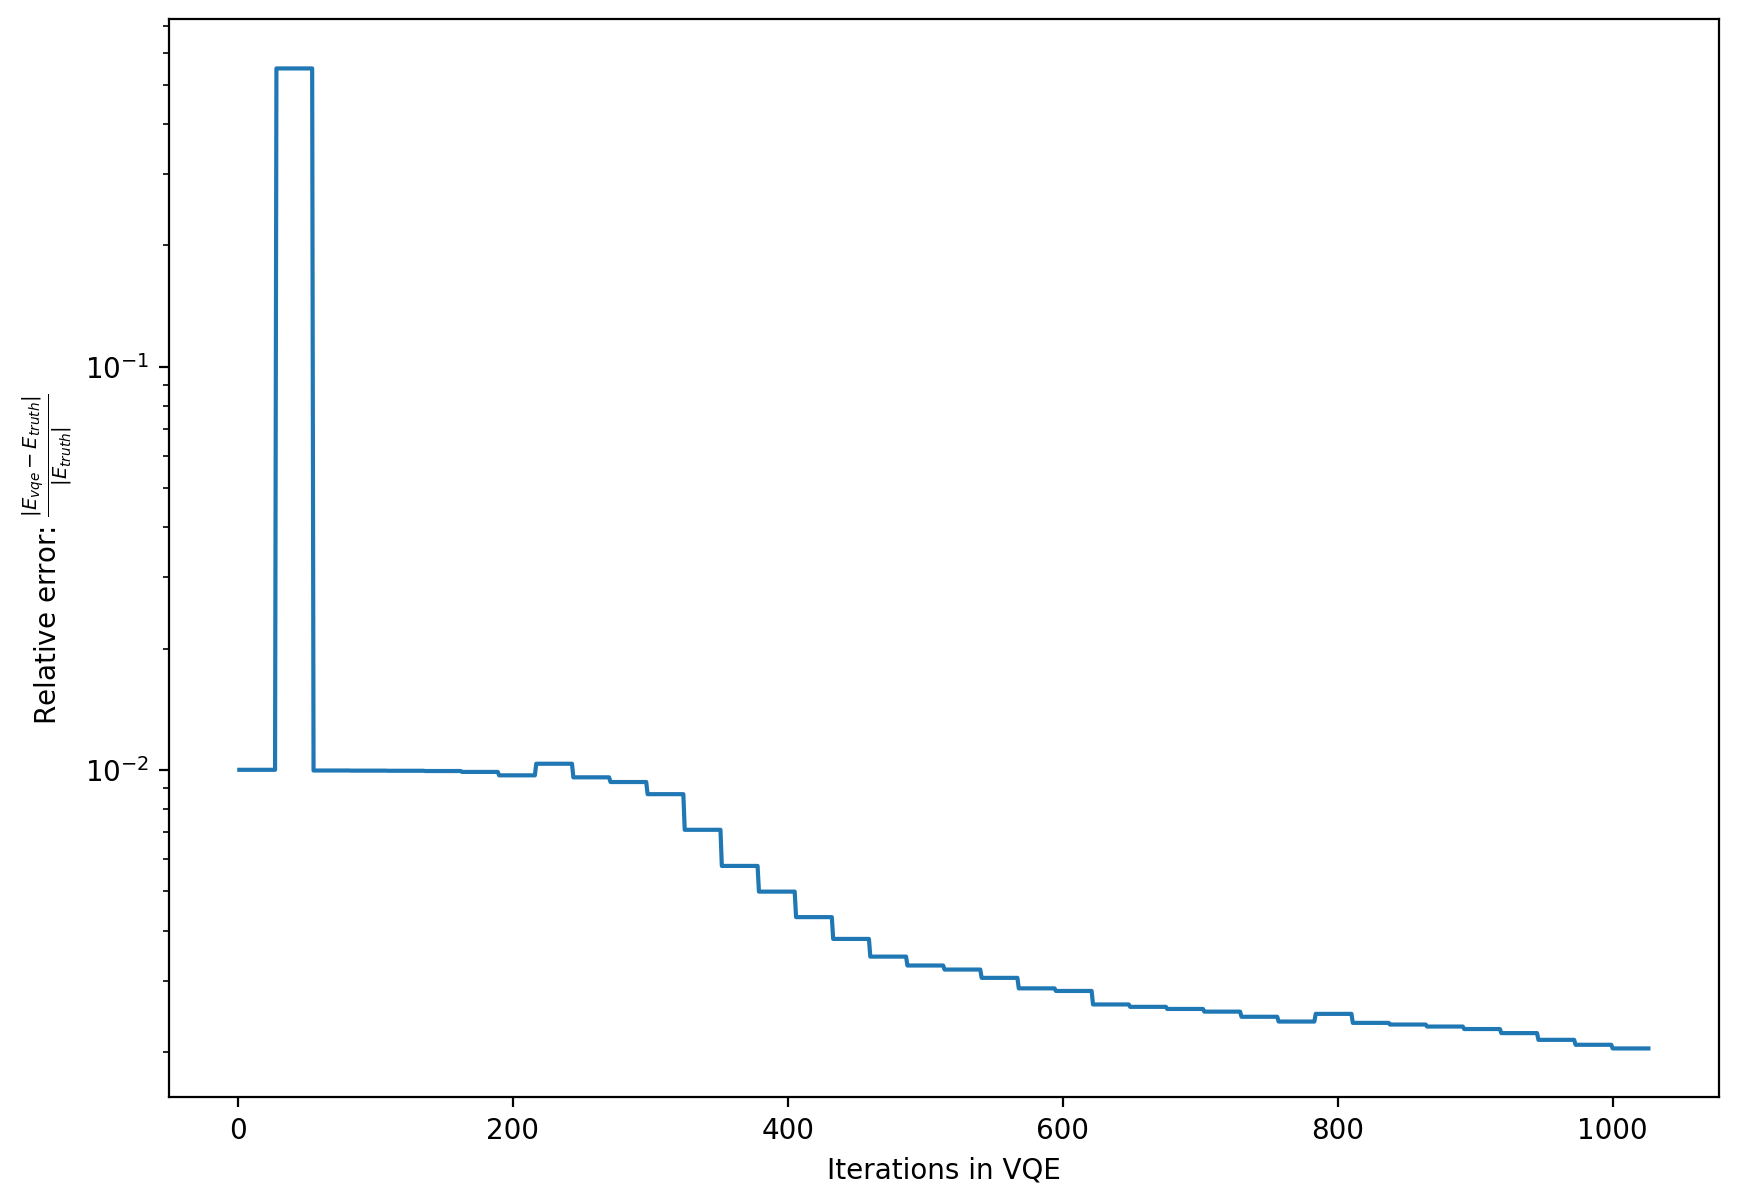

In [81]:
plt.figure(figsize=(10,7))
plt.semilogy(counts, ratio_energy)
plt.xlabel('Iterations in VQE')
plt.ylabel(r'Relative error: $\frac{|E_{vqe} - E_{truth}|}{|E_{truth}|}$')
#plt.legend(loc='best')

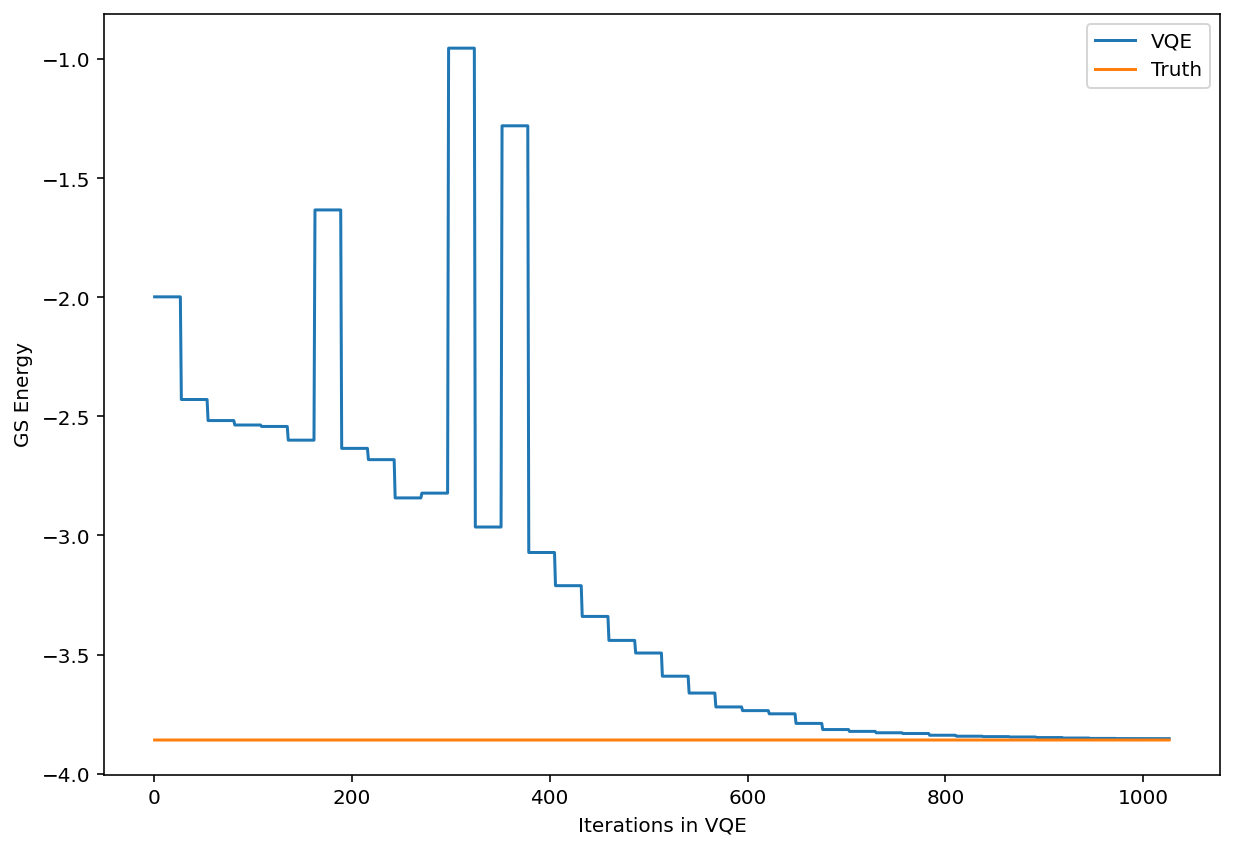

In [96]:
# Plot of gs energy vs iterations -- VQE without LO2MO
plt.figure(figsize=(10,7))
plt.plot(counts, values, label='VQE')
plt.plot(counts, gs_energy*np.ones(len(counts)), label='Truth')
plt.xlabel('Iterations in VQE')
plt.ylabel('GS Energy')
plt.legend(loc='best')

In [92]:
# r_E = |E_vqe - E_truth|/|E_truth|
np.abs(values[-1] - gs_energy)/np.abs(gs_energy)

0.0014624097020540848

In [ ]:
# As a diagnostic, might be useful to plot r_E for both VQE and classical diagonalization
# where we run the classical diagonalization on the updated Hamiltonian from the VQE side


No handles with labels found to put in legend.


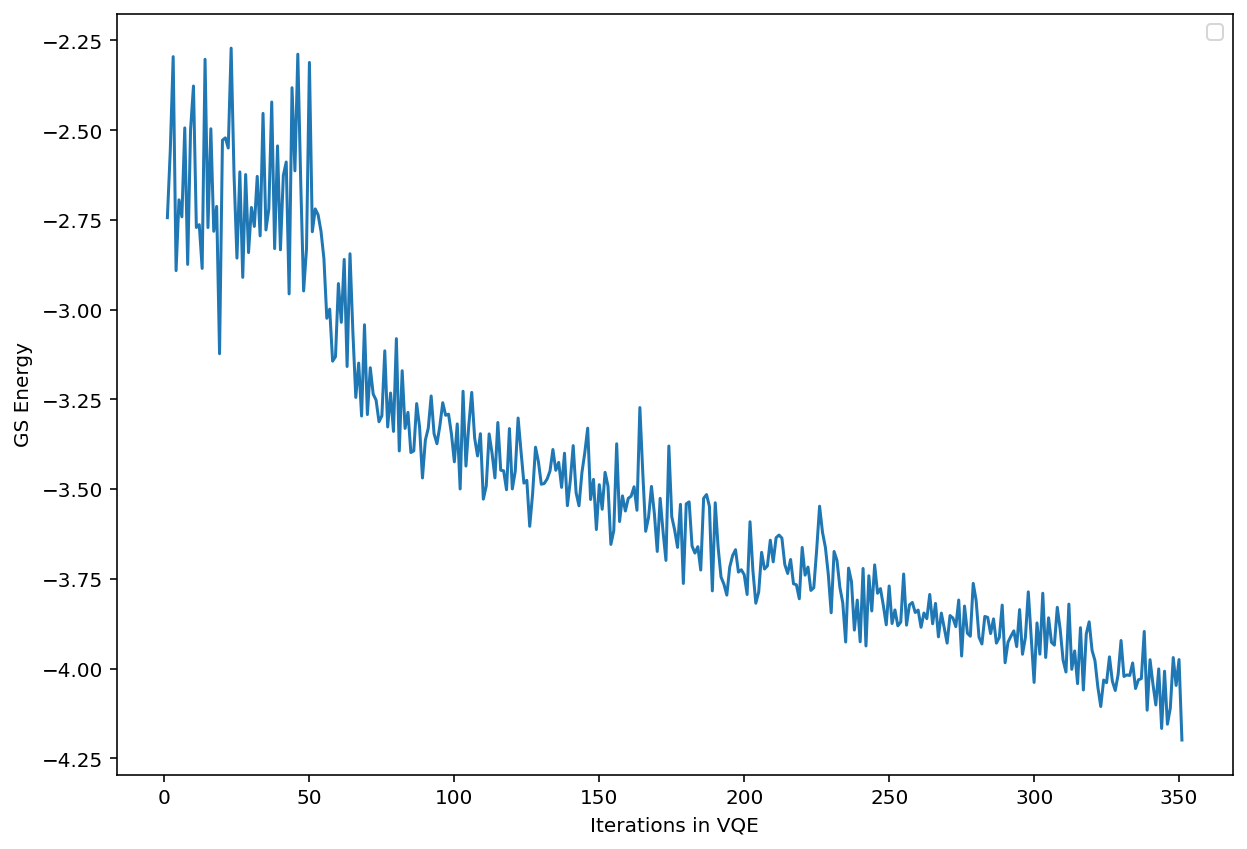

In [39]:
# Plot of gs energy vs iterations
# opt_iters = result_vqe['opt_tracker']['iters']
# opt_loss = result_vqe['opt_tracker']['loss']

plt.figure(figsize=(10,7))
plt.plot(counts, values)
#plt.plot(opt_iters, gs_energy*plt.ones(len(opt_iters)), label='Truth')
plt.xlabel('Iterations in VQE')
plt.ylabel('GS Energy')
plt.legend(loc='best')

Multiple questions:
- Why is it choppy?
- Why are we doing 1000 iters when max_iters is only like 125?
- What happens if I were to put in the LO2MO Transformation?
- For SPSA, you do fewer iterations even though it is very oscillatory now.
- Check that the ground state vectors look like.

In [ ]:
# Plot of gs energy vs iterations
opt_iters = result_vqe['opt_tracker']['iters']
opt_loss = result_vqe['opt_tracker']['loss']

plt.figure(figsize=(10,7))
plt.plot(opt_iters, opt_loss)
plt.plot(opt_iters, gs_energy*plt.ones(len(opt_iters)), label='Truth')
plt.xlabel('Iterations in VQE')
plt.ylabel('GS Energy')
plt.legend(loc='best')

# 1. QBE-VQE

## 1.1 Initialization

In [45]:
reload_package(qbe)

In [46]:
# fragment info
n_frags = 2
n_qubits = 8

labels_fragments = ['0', '1']
fragment_info = {'0': [0,1,2,4,5,6],'1': [0,1,2,4,5,6]}
fragment_nb = {'0': {'1': {'n_sites': 2, 'edge': [(2,1),(6,5)], 'center': [(1,0),(5,4)]}}, 
                    '1': {'0': {'n_sites': 2, 'edge': [(0,1),(4,5)], 'center': [(1,2),(5,6)]}}}

In [47]:
fragment_hams = {f: None for f in labels_fragments}

for f in labels_fragments:
    fragment_hams[f] = pd_fragments_H4_init[f].to_spmatrix()

In [48]:
scipy.sparse.issparse(fragment_hams[f])

True

In [49]:
qbe_fragment_init = qbe.fragment_hamiltonian.qbe_fragment_qubit(n_frags, n_qubits, labels_fragments,
                                                                fragment_info, 
                                                                fragment_nb, fragment_hams, 
                                                                target_fragment_H=pd_fragments_H4_init)

## 1.2 Classical Diagonalization -- Linear Constraints

In [50]:
qbe_fragment_lin_classical = copy.deepcopy(qbe_fragment_init)

In [51]:
func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(-n_iter/50))

optimizer_options = {'max_iters': 150, 'LR_init': 0.1, 
                     'LR_schedule': None,
                     'n_gd_iters': 1, 'THRES_GRAD': 1e-8}
qbe_solver_lin_classical = qbe.quantum_bootstrap.qbe_solver_qubit_pd(qbe_fragment_lin_classical, 
                                                                     type_constraint='linear',
                                                       optimizer_options=optimizer_options)

In [52]:
ds_classical_lin = qbe_solver_lin_classical.gd_solve()

Iter. number: 0
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 1
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 2
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 3
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 4
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 5
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 6
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 7
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 8
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 9
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 10
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 11
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 12
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 13
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) 

In [53]:
qbe_fragment_init.gs_energies

{'0': -3.8588128484366684, '1': -5.0476739005549325}

In [54]:
qbe_fragment_lin_classical.gs_energies

{'0': -3.459488696363636, '1': -4.9594886956004895}

In [55]:
qbe_fragment_lin_classical.gs_energies

{'0': -3.459488696363636, '1': -4.9594886956004895}

Text(0, 0.5, 'gradient after gradient descent \n(average over fragments)')

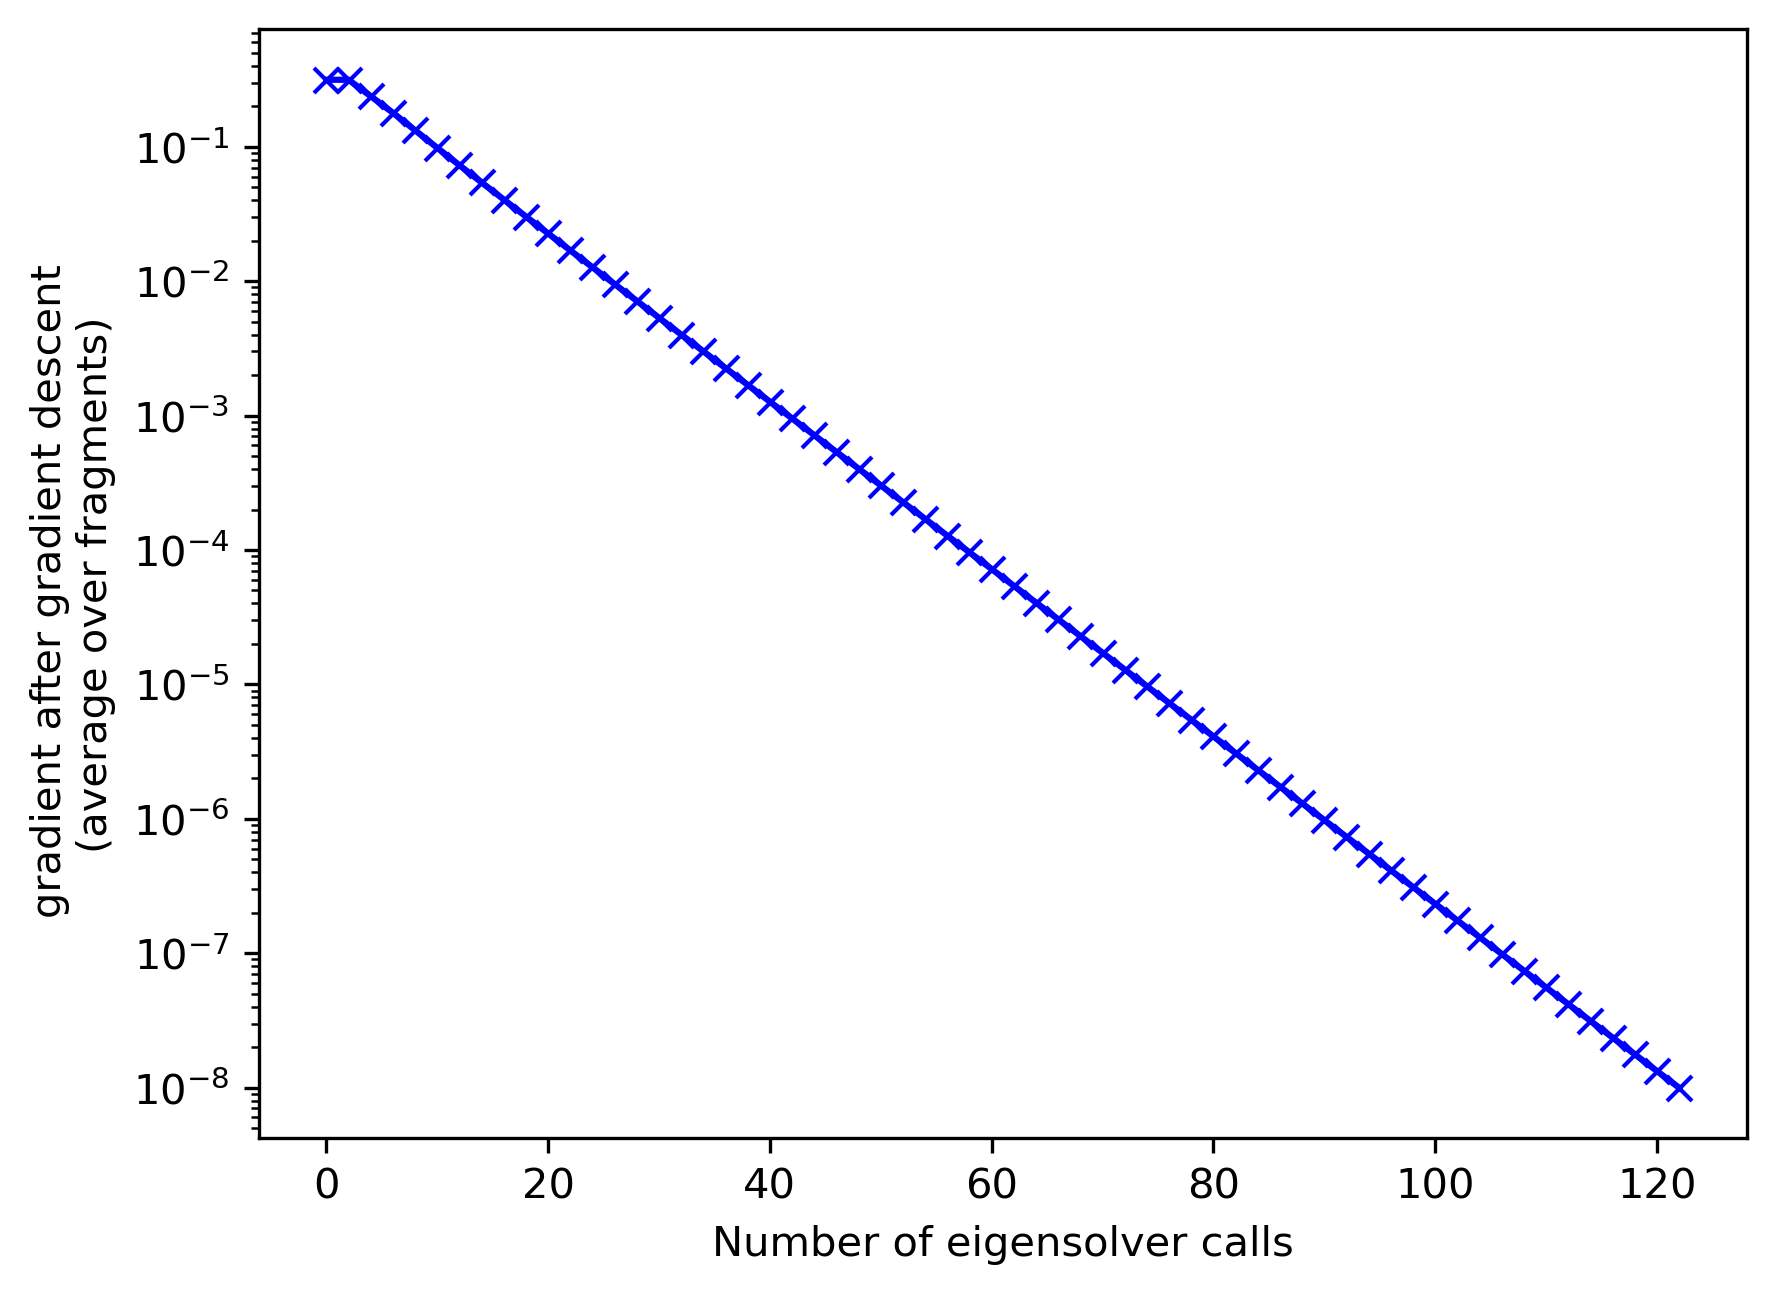

In [58]:
# Plotting
n_iter_classical = ds_classical_lin['iterations']
norm_gradients_classical = ds_classical_lin['norm_gradients']
rmse_error_classical = ds_classical_lin['rmse_error_fragment_rho']
n_eig_calls_classical = ds_classical_lin['n_eig_calls']

plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_classical, norm_gradients_classical, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')

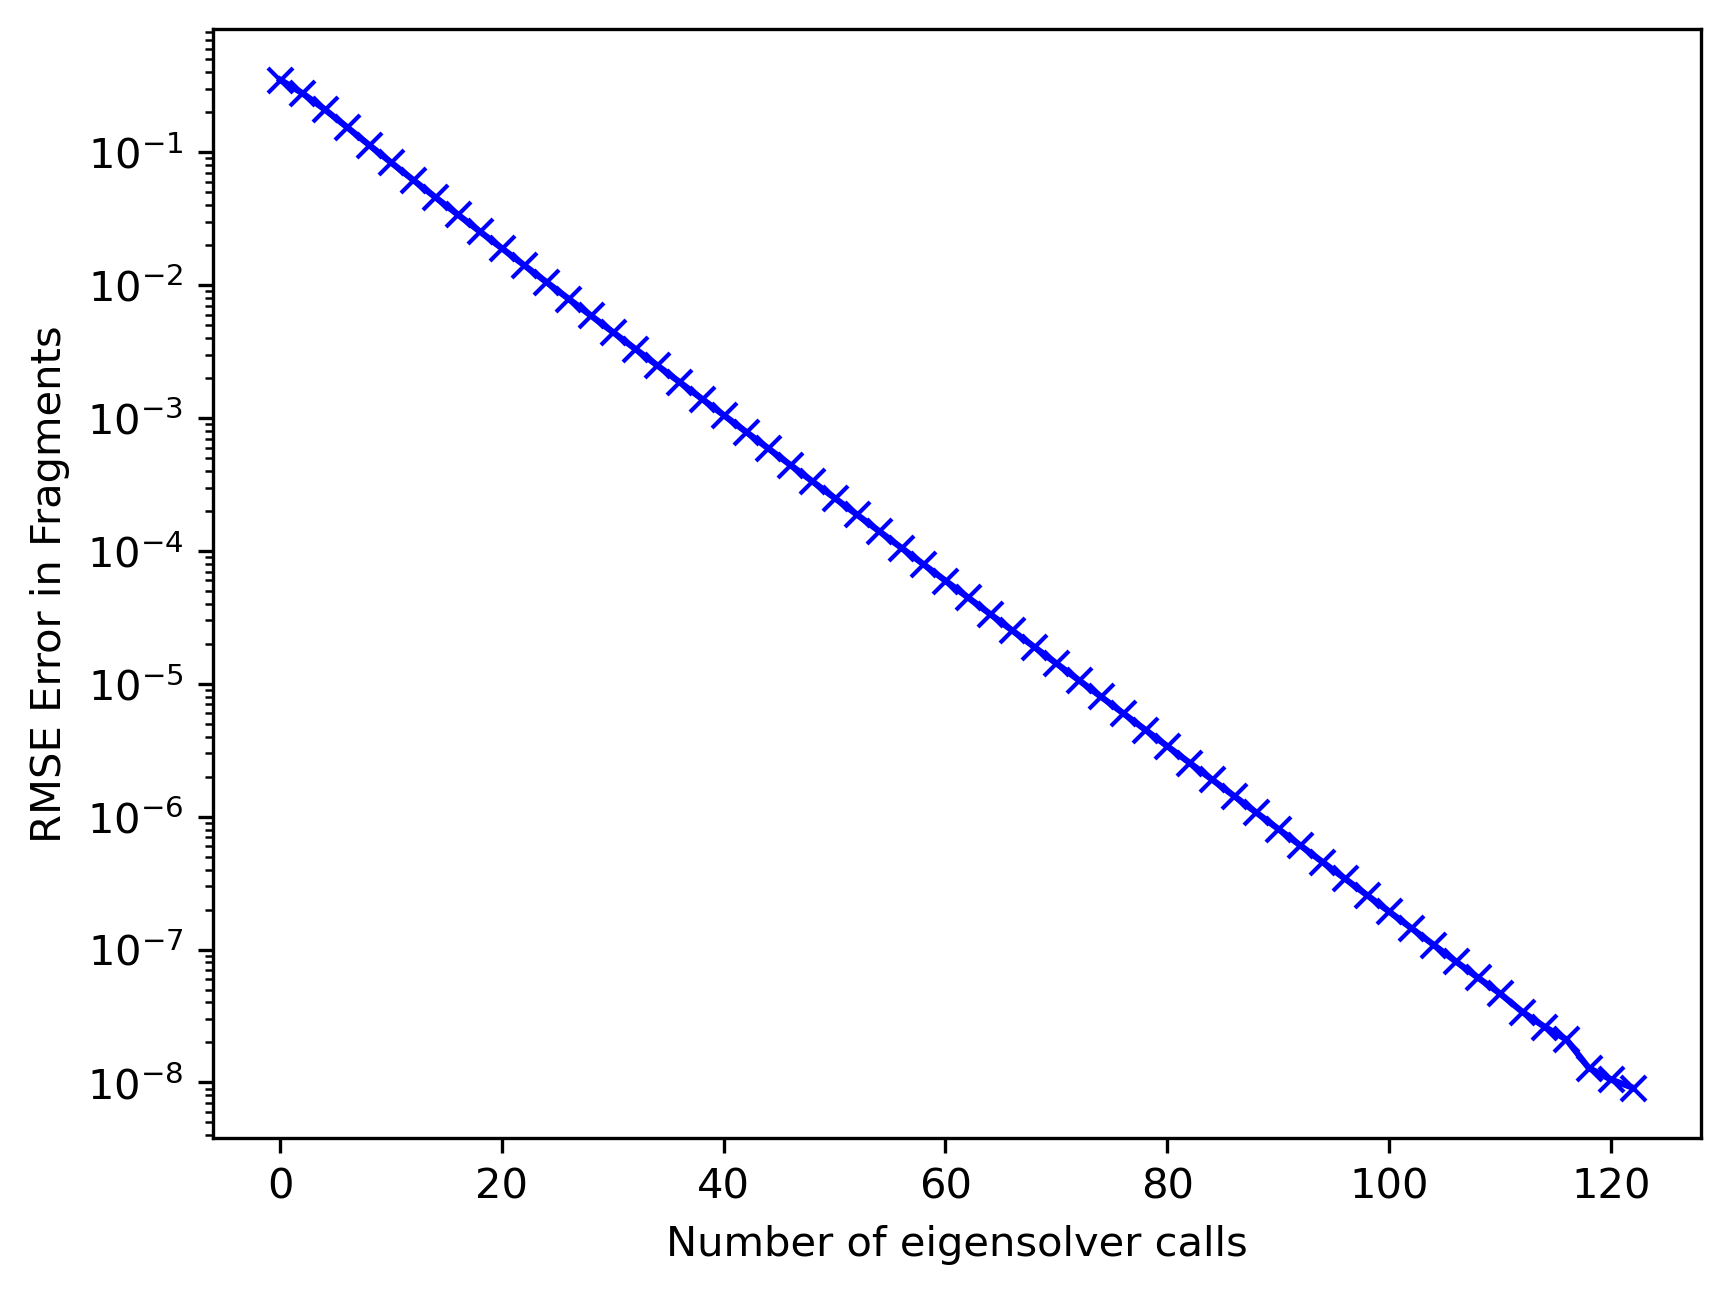

In [59]:
# Plot of RMSE Error in Fragments
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_classical, rmse_error_classical, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('RMSE Error in Fragments')
plt.show()

Text(0, 0.5, 'gradient after gradient descent \n(average over fragments)')

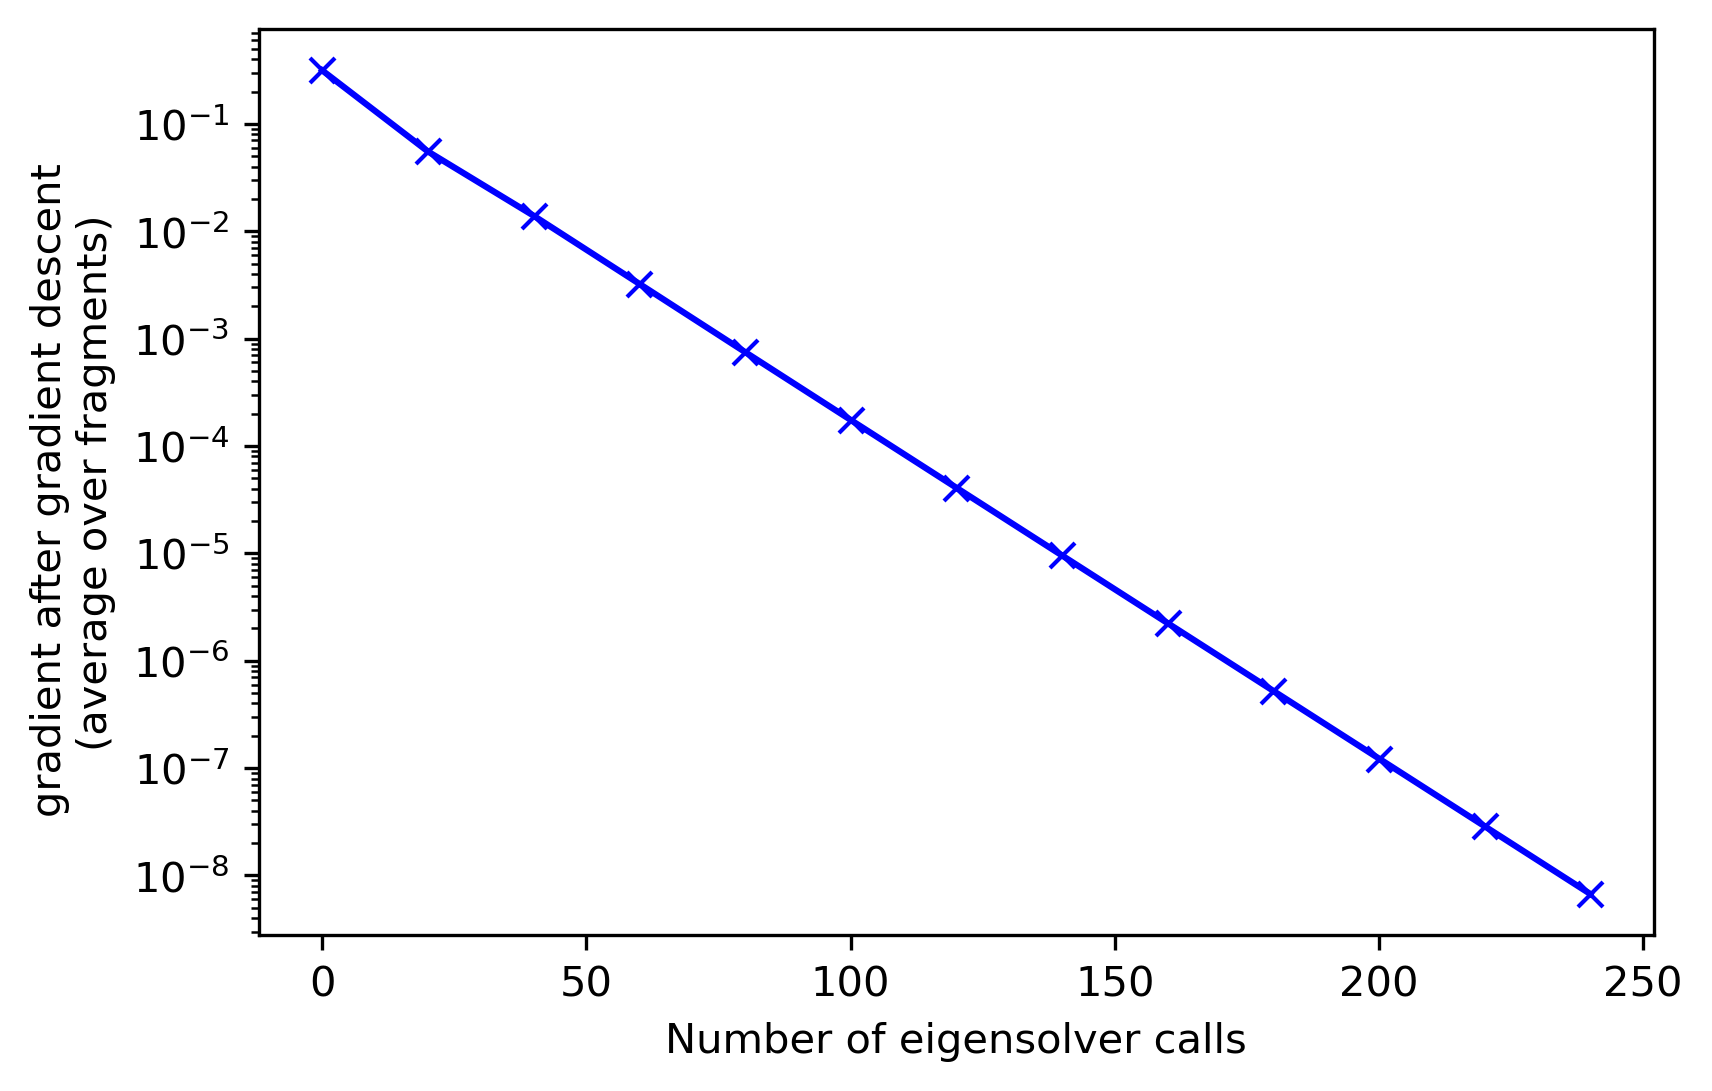

In [92]:
# Plotting
n_iter_classical = ds_classical_lin['iterations']
norm_gradients_classical = ds_classical_lin['norm_gradients']
rmse_error_classical = ds_classical_lin['rmse_error_fragment_rho']
n_eig_calls_classical = ds_classical_lin['n_eig_calls']

plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_classical, norm_gradients_classical, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')

/var/folders/z7/960_kj0n3fg8pz04mn8cyp_40000gn/T/ipykernel_22308/3797114212.py:7: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


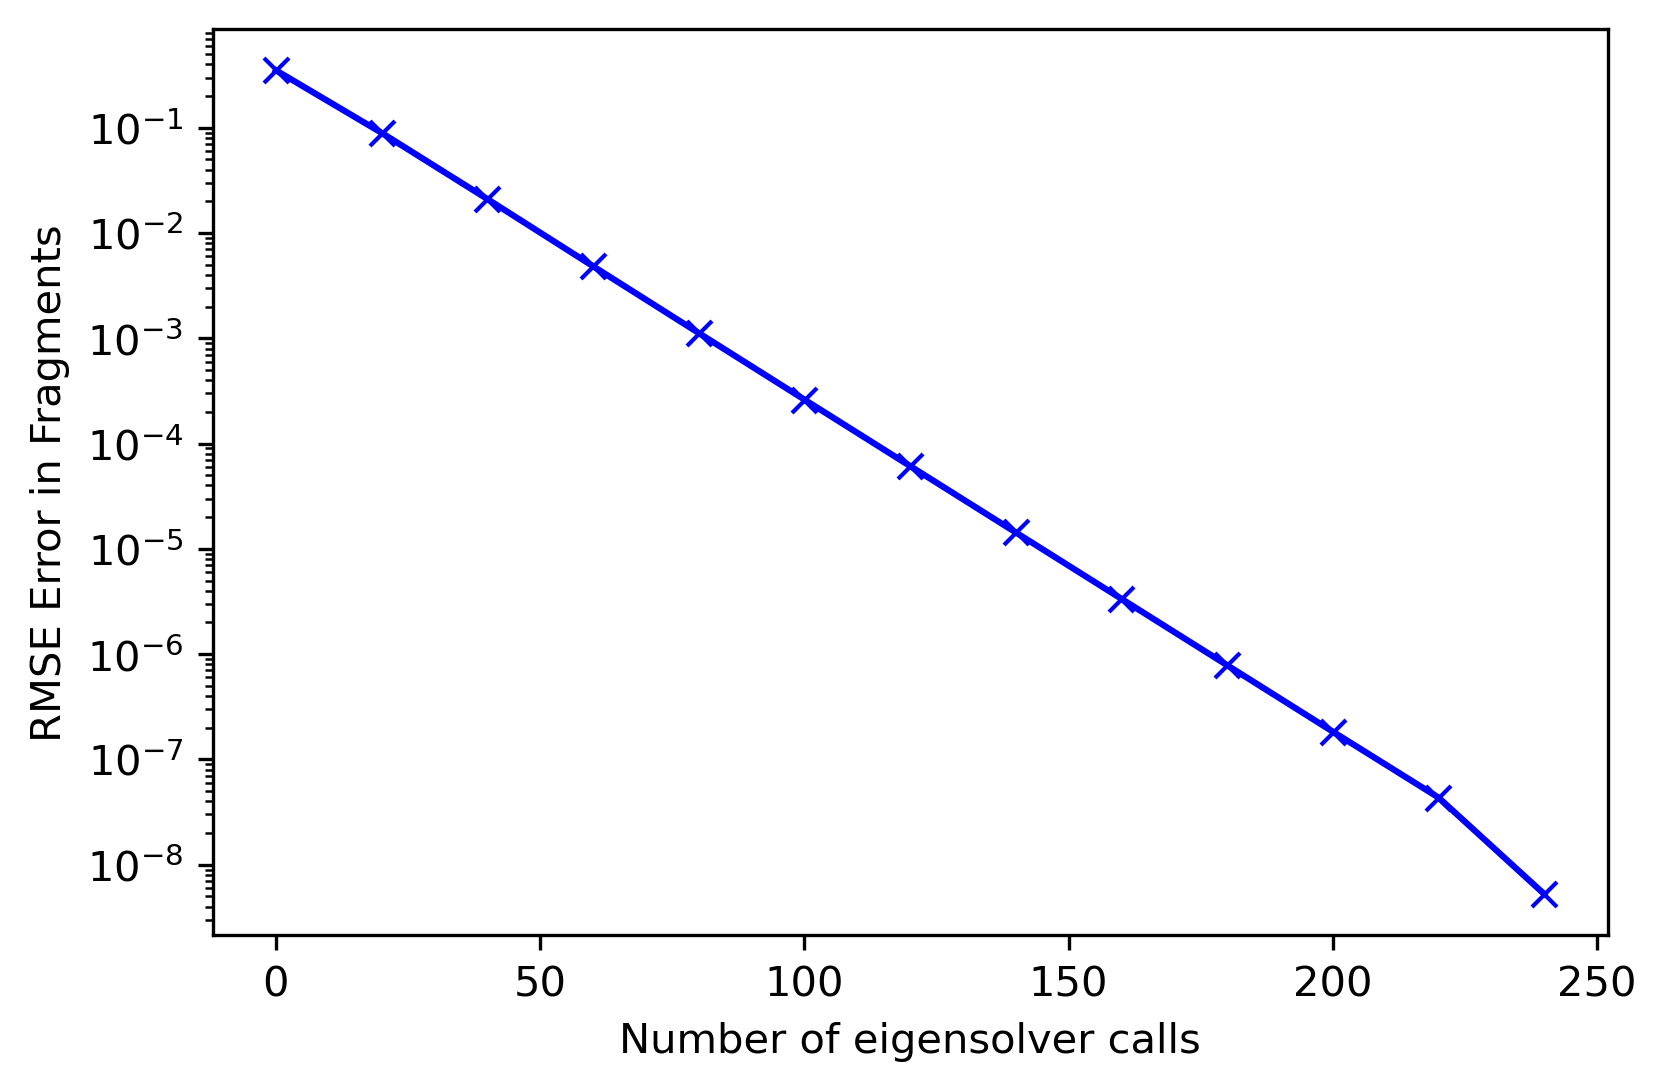

In [93]:
# Plot of RMSE Error in Fragments
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_classical, rmse_error_classical, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('RMSE Error in Fragments')
plt.show()

## 1.3 VQE -- Linear Constraints -- with LO2MO

In [60]:
reload_package(qbe)

In [61]:
# Create ansatz -- with HF state
qubit_converter = QubitConverter(mapper=JordanWignerMapper())

num_alpha = 2
num_beta = 2
num_particles = (num_alpha, num_beta)

num_molecular_orbitals = 4
num_spin_orbitals = 2*num_molecular_orbitals

# Initial state -- hf_state composed with U_LO2MO^dagg
hf_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
hf_state.compose(inv_U_lo2mo, inplace=True)

In [62]:
hf_state.draw()

┌───┐┌──────────────┐
q_0: ┤ X ├┤0             ├
     ├───┤│              │
q_1: ┤ X ├┤1             ├
     └───┘│              │
q_2: ─────┤2             ├
          │              │
q_3: ─────┤3             ├
     ┌───┐│  U_lo2mo_dag │
q_4: ┤ X ├┤4             ├
     ├───┤│              │
q_5: ┤ X ├┤5             ├
     └───┘│              │
q_6: ─────┤6             ├
          │              │
q_7: ─────┤7             ├
          └──────────────┘

In [63]:
# Define ansatz
#ansatz = ExcitationPreserving(num_qubits=n_qubits, mode='fsim', entanglement='full', reps=3, 
#                              initial_state=hf_state)

#ansatz = ExcitationPreserving(num_qubits=n_qubits, mode='fsim', entanglement='full', reps=3)

ansatz = UCCSD(qubit_converter, num_particles, num_spin_orbitals, reps=1, initial_state=hf_state)
#ansatz = UCCSD(qubit_converter, num_particles, num_spin_orbitals, reps=1, initial_state=None)

# Define backend
backend = Aer.get_backend('statevector_simulator')

In [64]:
# Initialize QBEVQESolver
vqe_solver = qbe.QBEVQESolver(n_qubits=8, ansatz=ansatz, backend=backend, FLAG_pauli_decomposition_instance=True)

### VQE Solve

In [65]:
qbe_fragment_lin_vqe = copy.deepcopy(qbe_fragment_init)

In [66]:
func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(-n_iter/50))

optimizer_options = {'max_iters': 50, 'LR_init': 0.1, 
                     'LR_schedule': None,
                     'n_gd_iters': 1, 'THRES_GRAD': 1e-8}

type_gs_solver = 'vqe'
qbe_solver_lin_vqe = qbe.quantum_bootstrap.qbe_solver_qubit_pd(qbe_fragment_lin_vqe, type_constraint='linear',
                                                               type_gs_solver=type_gs_solver, 
                                                               gs_solver=vqe_solver,
                                                               optimizer_options=optimizer_options)

In [67]:
ds_vqe = qbe_solver_lin_vqe.gd_solve()

Iter. number: 0
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 1
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 2
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 3
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 4
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 5
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 6
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 7
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 9
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 10
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 11
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 12
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 13
(f,nb_f,n_iter) = (0, 1, 0)
(f,nb_f,n_iter) = (1, 0, 0)
Iter. number: 14
(f,nb_f,n_iter)

In [83]:
# get dictionaries
def dict_info_of_qbe_fragment(qbe_frag):
    dict_info = {'n_frag': copy.deepcopy(qbe_frag.n_frag),
                 'n_qubits': copy.deepcopy(qbe_frag.n_qubits),
                 'n_qubits_overlapping_site': copy.deepcopy(qbe_frag.n_qubits_overlapping_site),
                 'labels': copy.deepcopy(qbe_frag.labels),
                 'info': copy.deepcopy(qbe_frag.info),
                 'H': copy.deepcopy(qbe_frag.H),
                 'paulisumop_H': copy.deepcopy(qbe_frag.paulisumop_H),
                 'target_H': copy.deepcopy(qbe_frag.target_H),
                 'neighbors': copy.deepcopy(qbe_frag.neighbors),
                 'gs_energies': copy.deepcopy(qbe_frag.gs_energies),
                 'ground_state': copy.deepcopy(qbe_frag.ground_state),
                 'rho_E': copy.deepcopy(qbe_frag.rho_E),
                 'rho_C': copy.deepcopy(qbe_frag.rho_C),
                 'sigma_rho_E': copy.deepcopy(qbe_frag.sigma_rho_E),
                 'sigma_rho_C': copy.deepcopy(qbe_frag.sigma_rho_C),
                 'overlap_P': copy.deepcopy(qbe_frag.overlap_P)}
    
    return dict_info

In [85]:
dict_info_init = dict_info_of_qbe_fragment(qbe_fragment_init)
dict_info_lin_classical = dict_info_of_qbe_fragment(qbe_fragment_lin_classical)
dict_info_lin_vqe = dict_info_of_qbe_fragment(qbe_fragment_lin_vqe)

In [86]:
# Lets dump ds_vqe and ds_classical stuff here as well as the final states
file = open('vqe_H4_paulisumop_solver_LO2MO', 'wb')

data = [ds_classical_lin, ds_vqe, dict_info_init, dict_info_lin_classical, dict_info_lin_vqe] 

pickle.dump(data, file)

# close the file
file.close()

Text(0, 0.5, 'gradient after gradient descent \n(average over fragments)')

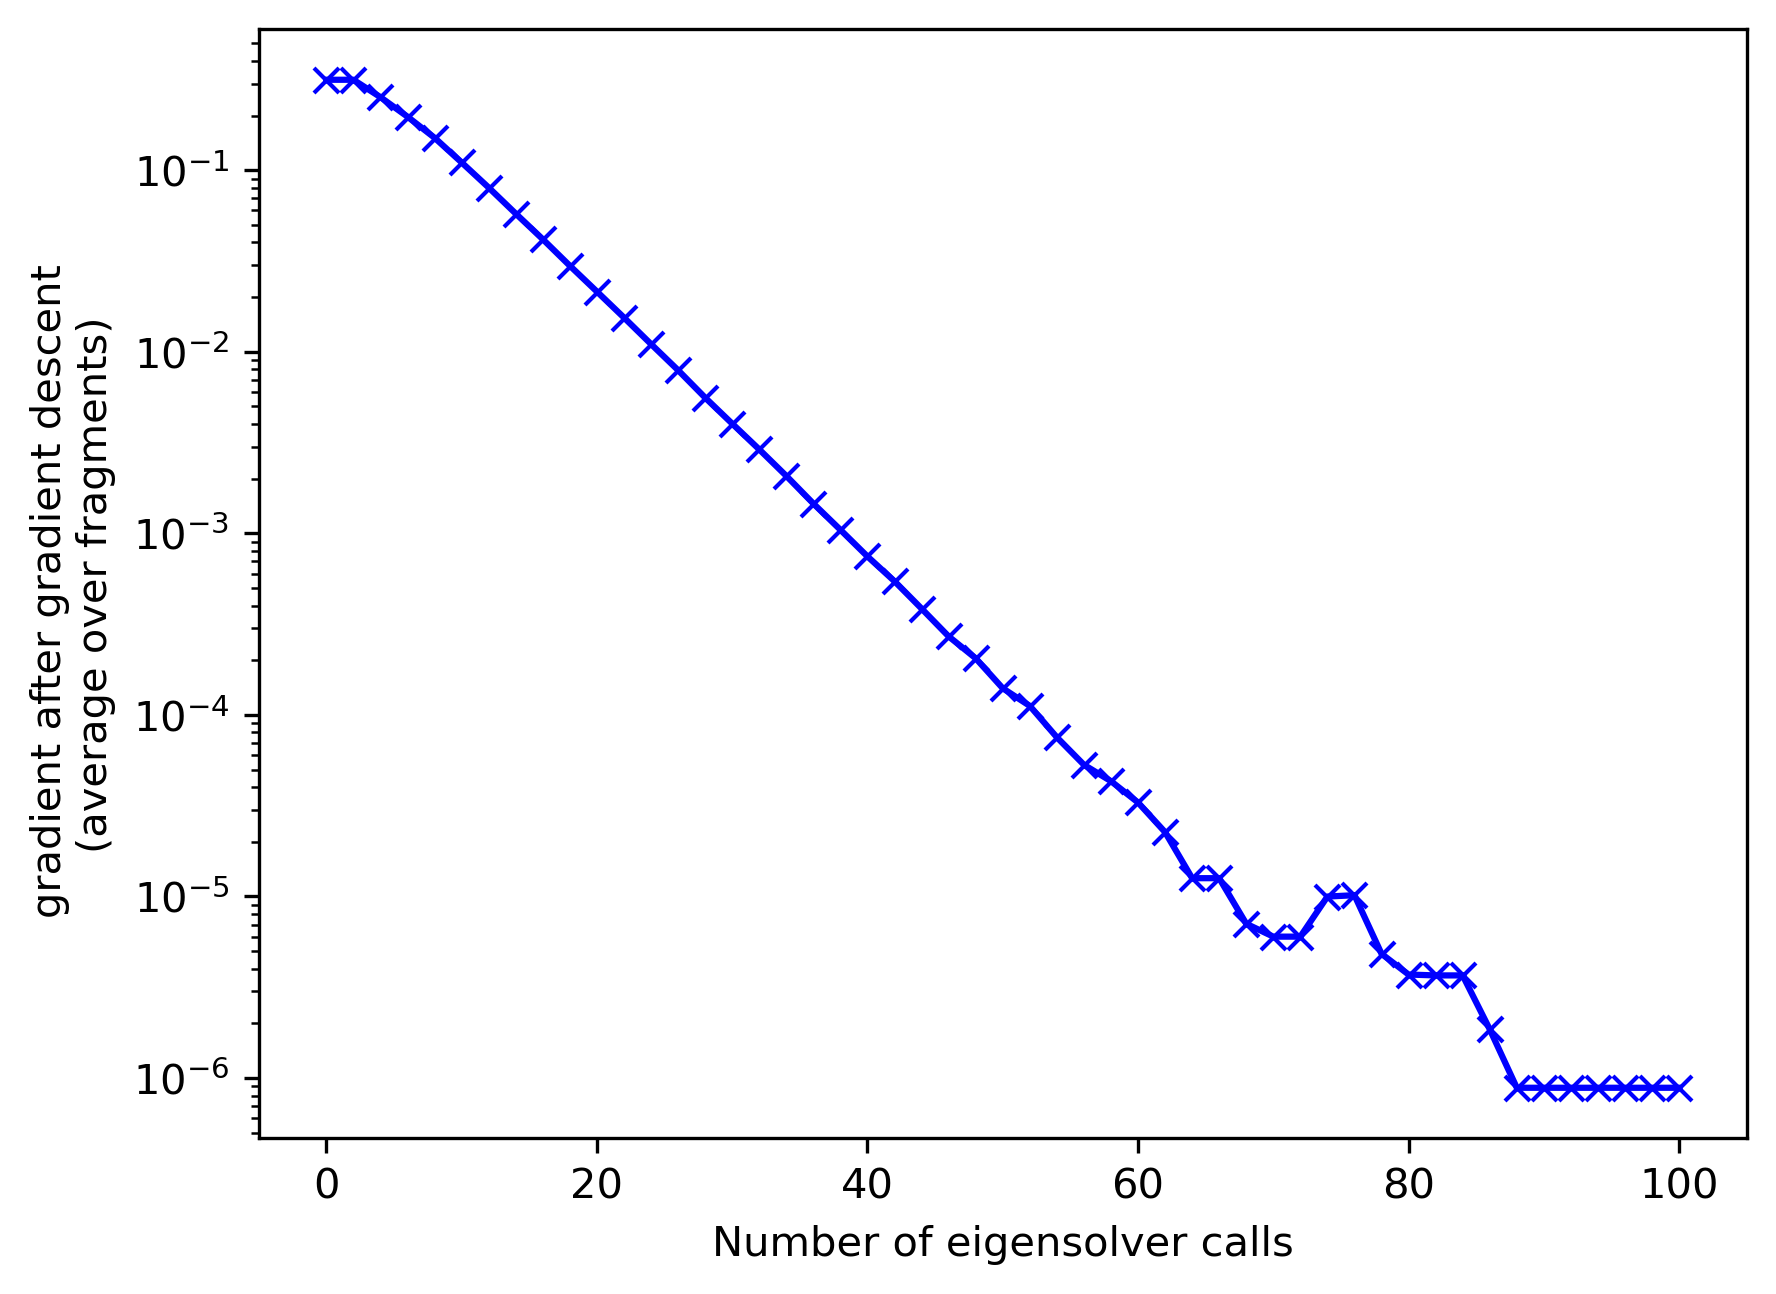

In [70]:
# Plotting
n_iter_vqe = ds_vqe['iterations']
norm_gradients_vqe = ds_vqe['norm_gradients']
rmse_error_vqe = ds_vqe['rmse_error_fragment_rho']
n_eig_calls_vqe = ds_vqe['n_eig_calls']

plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_vqe, norm_gradients_vqe, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')

Text(0, 0.5, 'RMSE')

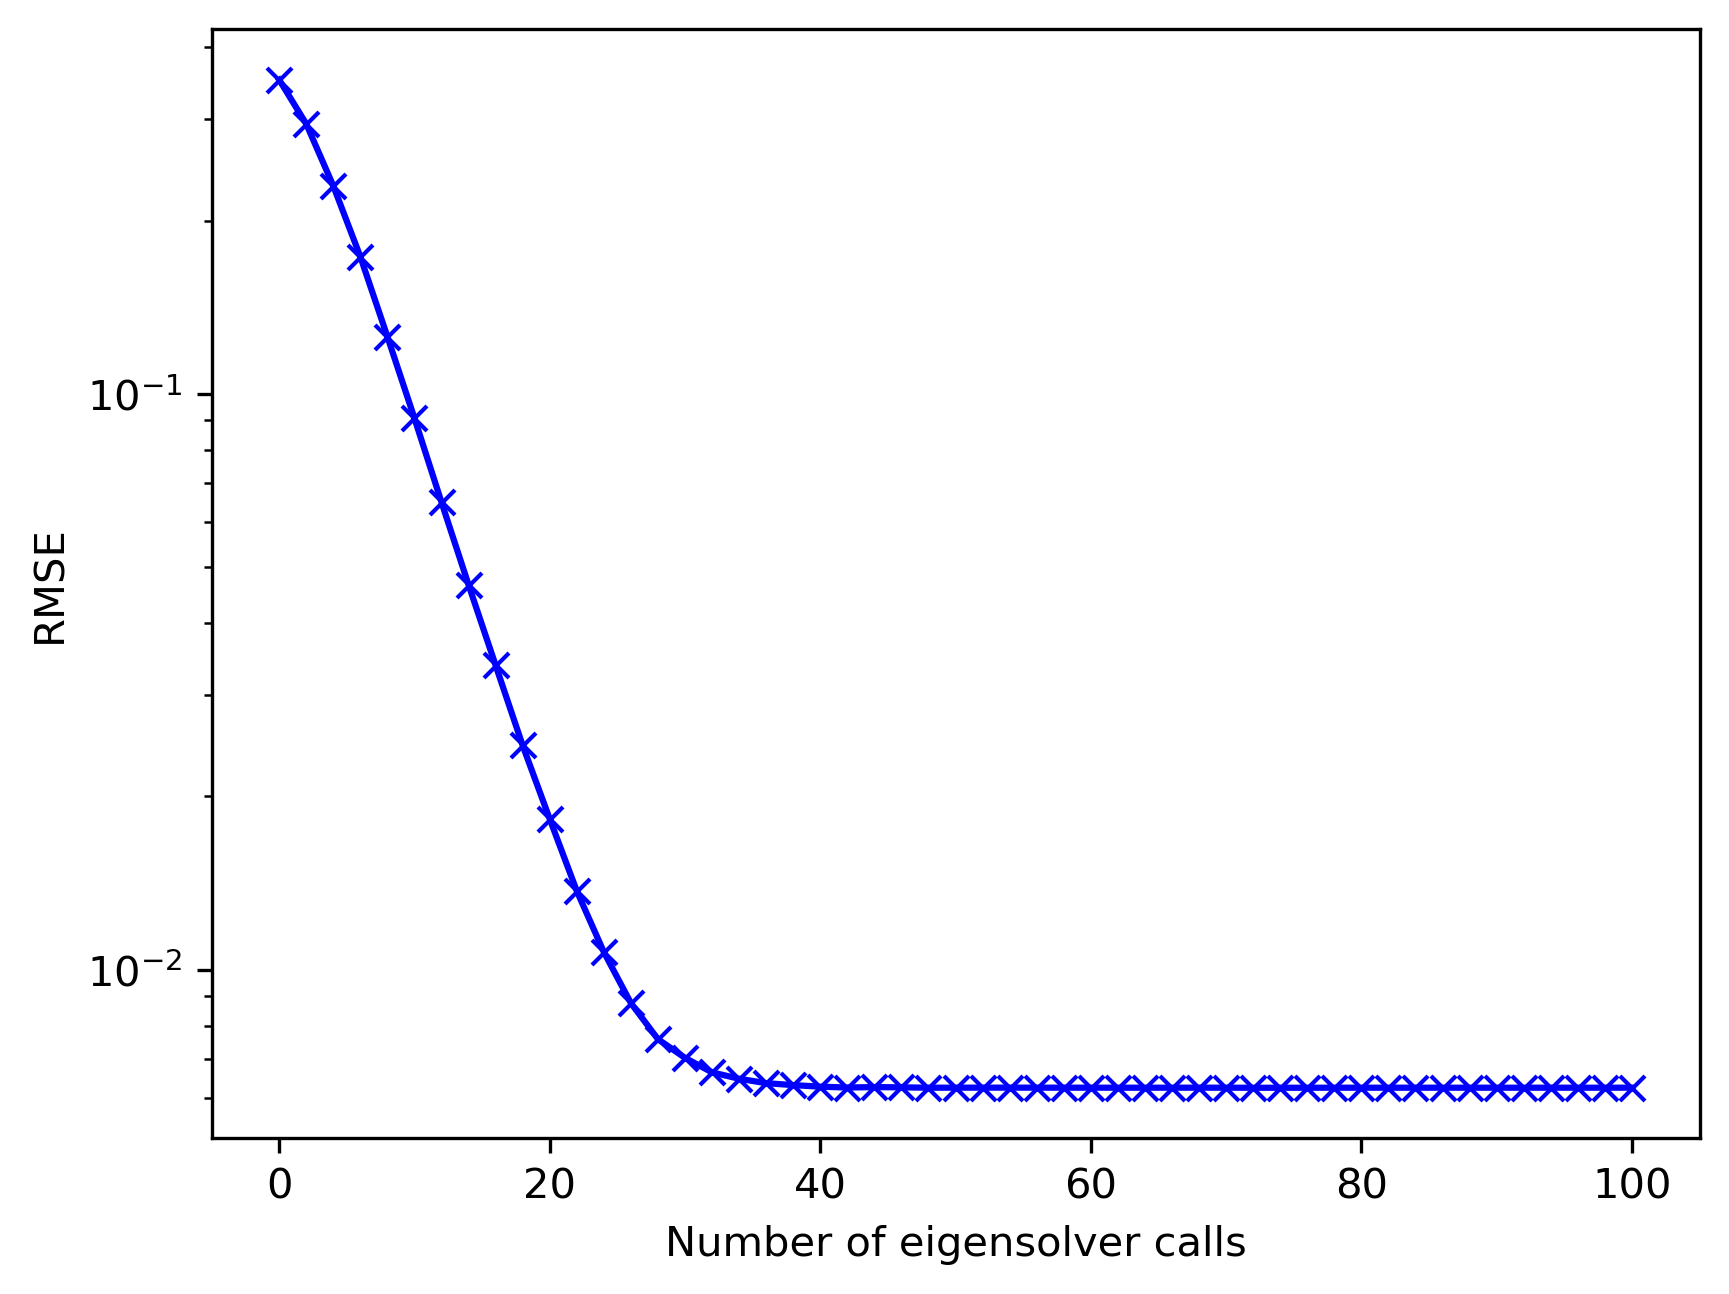

In [71]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_vqe, rmse_error_vqe, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('RMSE')

In [87]:
pauli_update_f0nb1_Z1_vqe = [ds_vqe['updated_paulis']['0']['1'][n_iter][0][1] for n_iter in range(50)]
pauli_update_f0nb1_Z2_vqe = [ds_vqe['updated_paulis']['0']['1'][n_iter][1][1] for n_iter in range(50)]

In [88]:
pauli_update_f1nb0_Z1_vqe = [ds_vqe['updated_paulis']['1']['0'][n_iter][0][1] for n_iter in range(50)]
pauli_update_f1nb0_Z2_vqe = [ds_vqe['updated_paulis']['1']['0'][n_iter][1][1] for n_iter in range(50)]

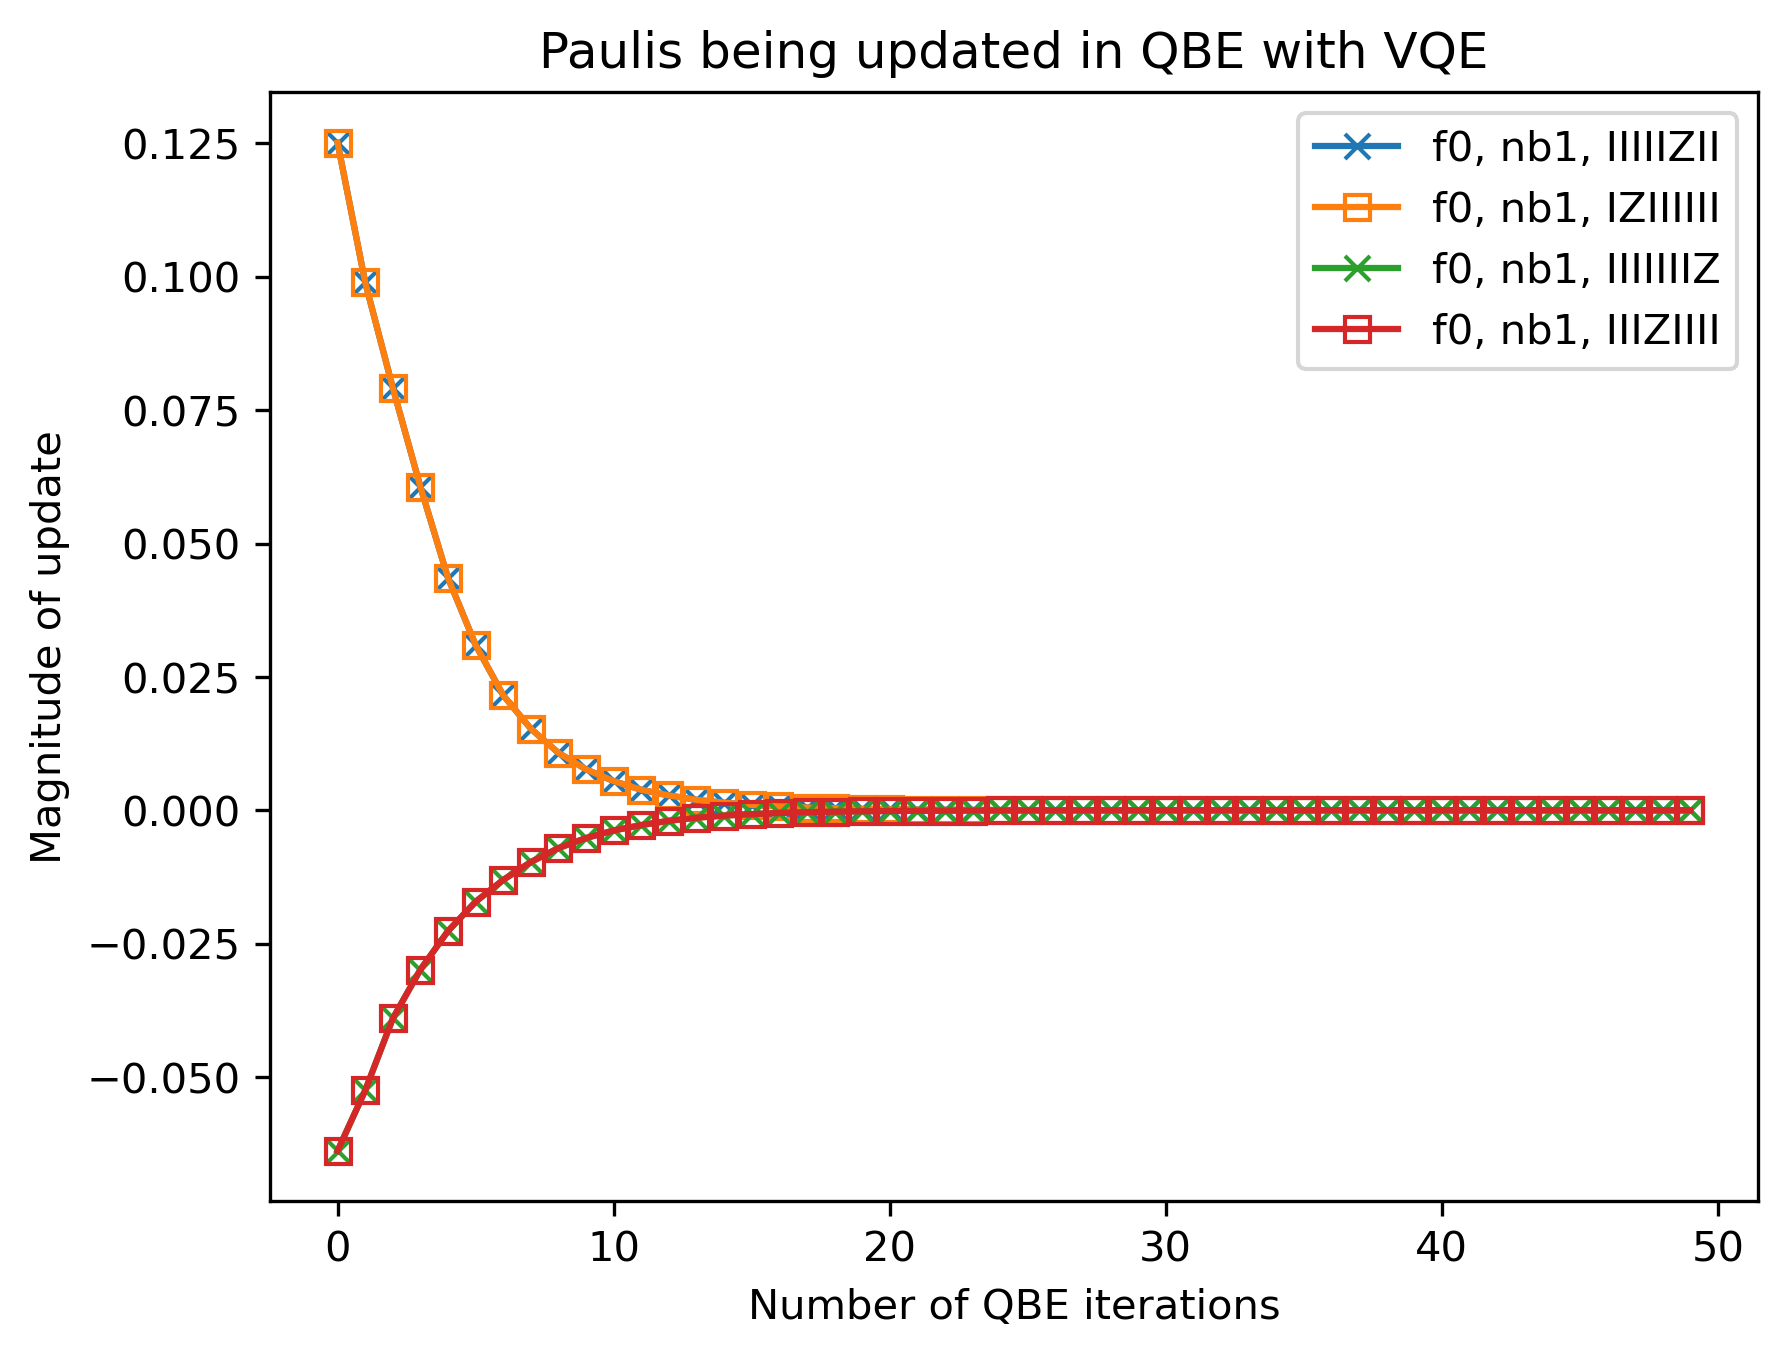

In [89]:
plt.figure(dpi = 150)
plt.plot(range(50), pauli_update_f0nb1_Z1_vqe, '-x', mfc='none', label='f0, nb1, '+ds_vqe['updated_paulis']['0']['1'][0][0][0])
plt.plot(range(50), pauli_update_f0nb1_Z2_vqe, '-s', mfc='none', label='f0, nb1, '+ds_vqe['updated_paulis']['0']['1'][0][1][0])


plt.plot(range(50), pauli_update_f1nb0_Z1_vqe, '-x', mfc='none', label='f0, nb1, '+ds_vqe['updated_paulis']['1']['0'][0][0][0])
plt.plot(range(50), pauli_update_f1nb0_Z2_vqe, '-s', mfc='none', label='f0, nb1, '+ds_vqe['updated_paulis']['1']['0'][0][1][0])
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of QBE iterations')
plt.ylabel('Magnitude of update')
plt.title('Paulis being updated in QBE with VQE')
plt.legend(loc='best')

### Summary

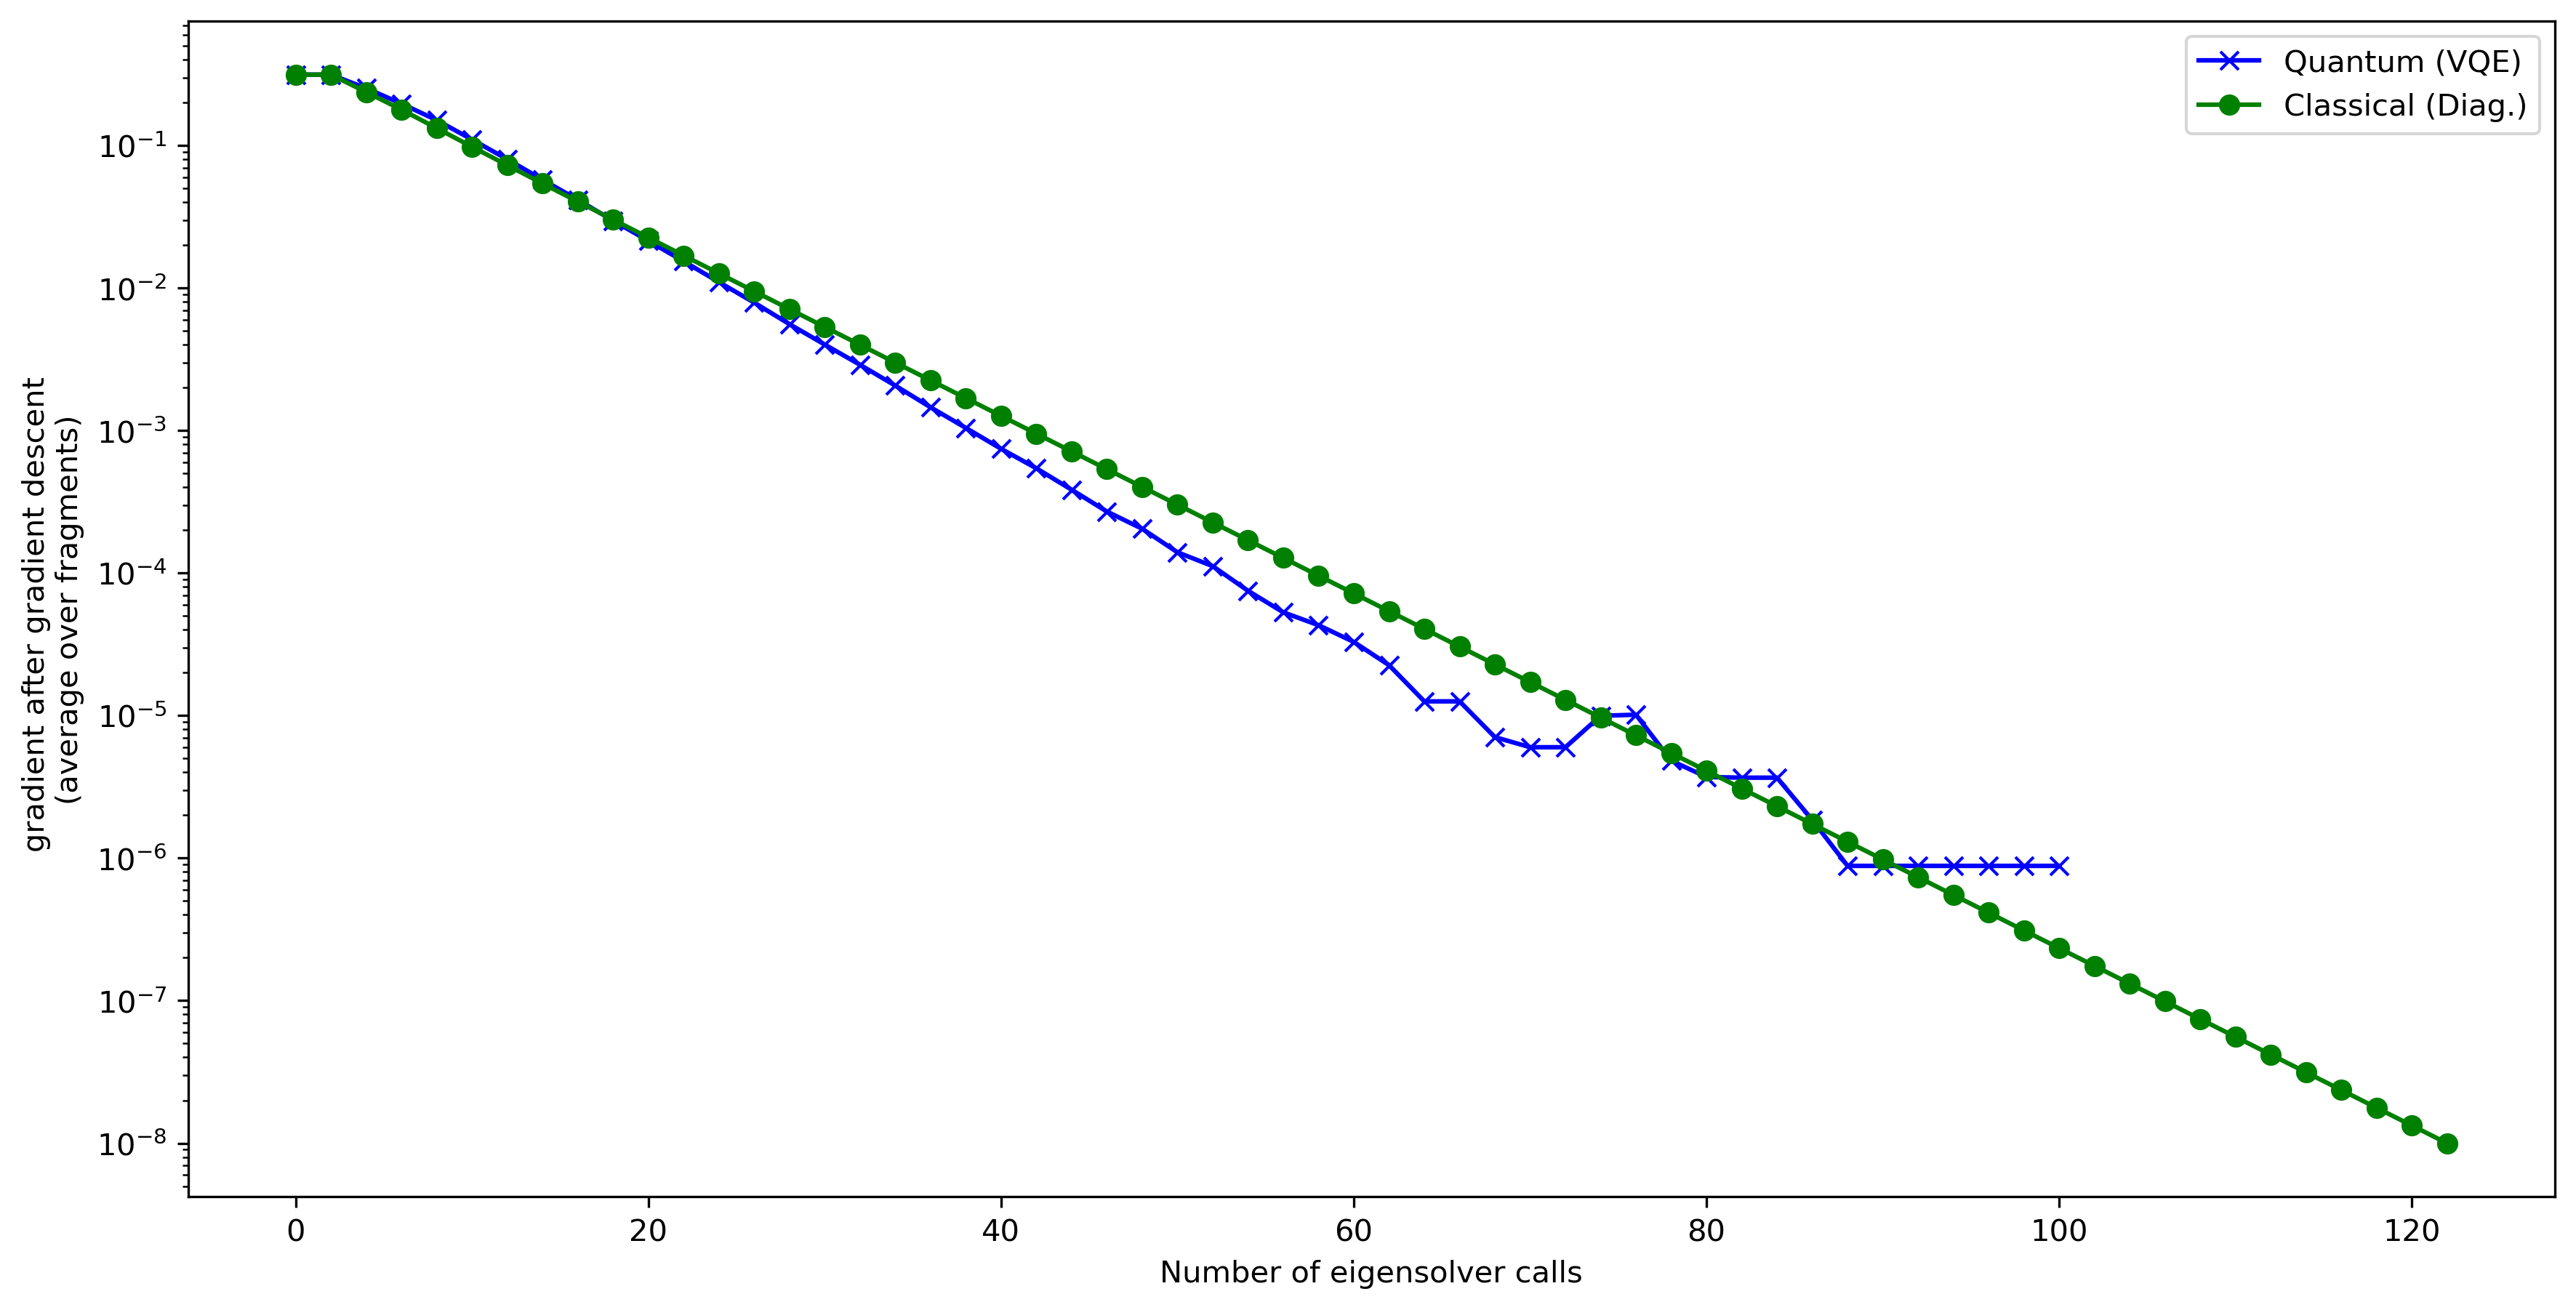

In [72]:
plt.figure(figsize=(14,7), dpi = 150)
plt.semilogy(n_eig_calls_vqe, norm_gradients_vqe, '-x', c='b', label='Quantum (VQE)')
plt.semilogy(n_eig_calls_classical, norm_gradients_classical, '-o', c='g', label='Classical (Diag.)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.legend(loc='upper right')
plt.savefig('comparison_H4_v2_LO2MO.png', bbox_inches='tight')

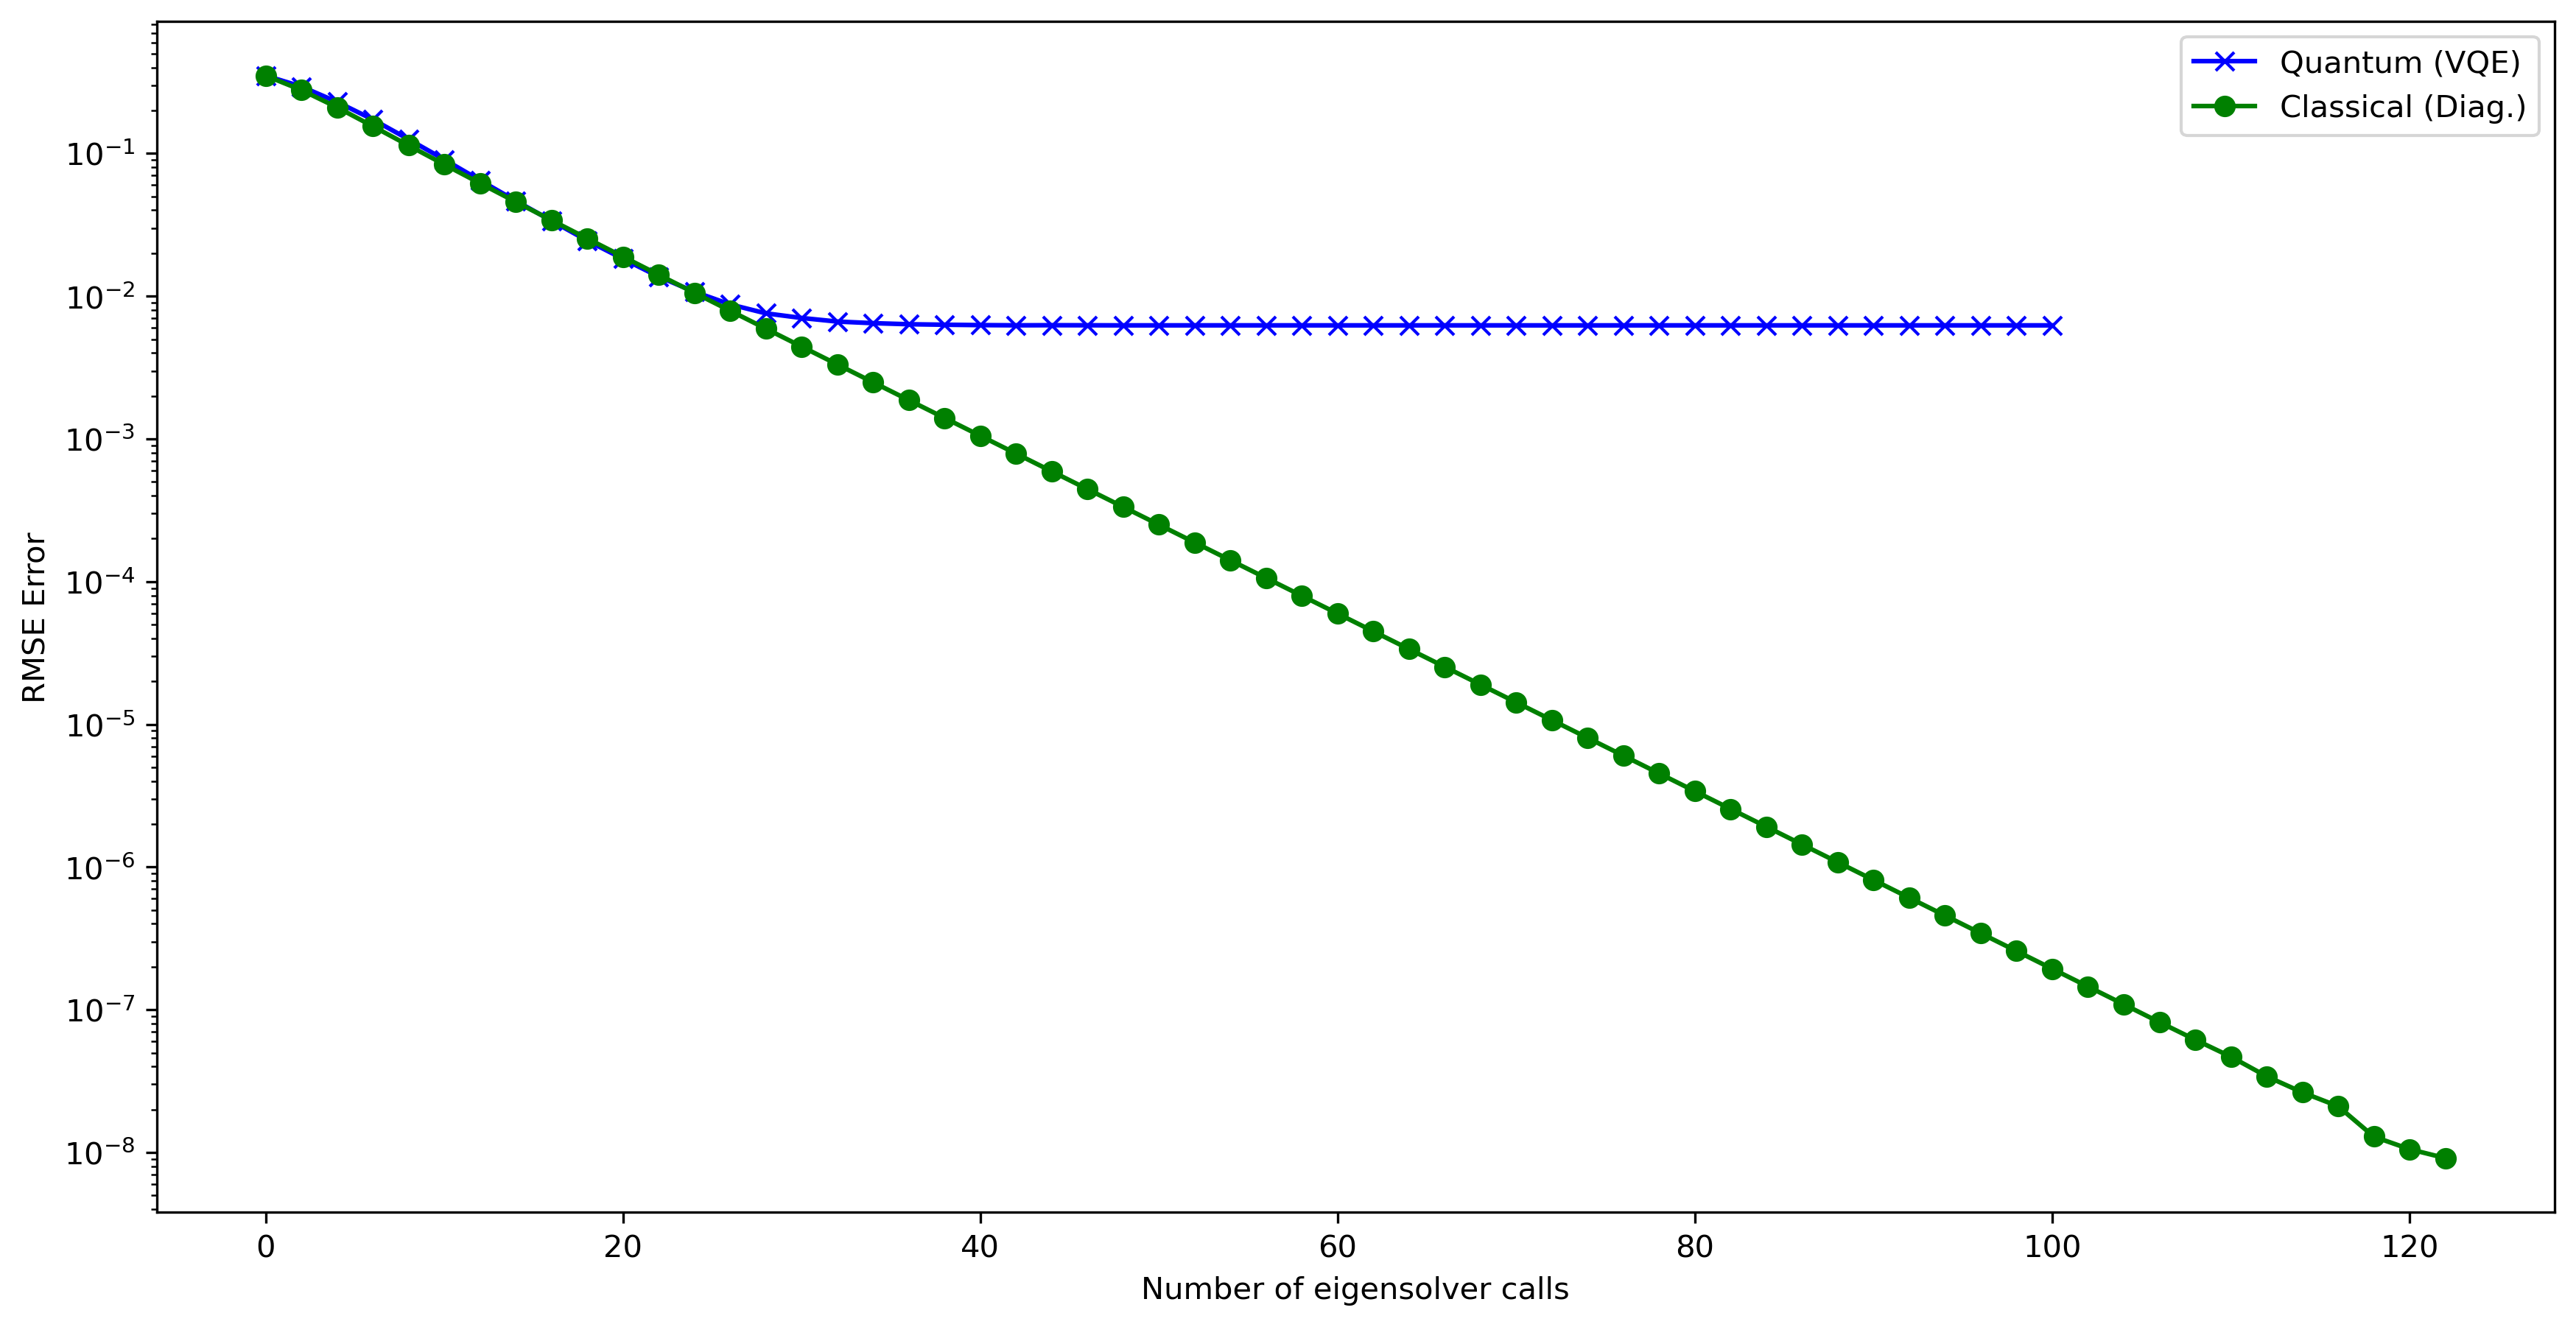

In [73]:
plt.figure(figsize=(14,7), dpi = 150)
plt.semilogy(n_eig_calls_vqe, rmse_error_vqe, '-x', c='b', label='Quantum (VQE)')
plt.semilogy(n_eig_calls_classical, rmse_error_classical, '-o', c='g', label='Classical (Diag.)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('RMSE Error')
plt.legend(loc='upper right')
plt.savefig('comparison_H4_v2_LO2MO.png', bbox_inches='tight')

### Summary of loaded data

In [41]:
file = open('vqe_H4_paulisumop_solver_LO2MO', 'rb')

data_H4 = pickle.load(file)
ds_classical_lin, ds_vqe, dict_info_init, dict_info_lin_classical, dict_info_lin_vqe = data_H4

file.close()

/var/folders/z7/960_kj0n3fg8pz04mn8cyp_40000gn/T/ipykernel_6132/270890900.py:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data_H4 = pickle.load(file)


In [42]:
# VQE Updates
pauli_update_f0nb1_Z1_vqe = [ds_vqe['updated_paulis']['0']['1'][n_iter][0][1] for n_iter in range(50)]
pauli_update_f0nb1_Z2_vqe = [ds_vqe['updated_paulis']['0']['1'][n_iter][1][1] for n_iter in range(50)]

pauli_update_f1nb0_Z1_vqe = [ds_vqe['updated_paulis']['1']['0'][n_iter][0][1] for n_iter in range(50)]
pauli_update_f1nb0_Z2_vqe = [ds_vqe['updated_paulis']['1']['0'][n_iter][1][1] for n_iter in range(50)]

In [43]:
# Classical updates
pauli_update_f0nb1_Z1_class = [ds_classical_lin['updated_paulis']['0']['1'][n_iter][0][1] for n_iter in range(61)]
pauli_update_f0nb1_Z2_class = [ds_classical_lin['updated_paulis']['0']['1'][n_iter][1][1] for n_iter in range(61)]

pauli_update_f1nb0_Z1_class = [ds_classical_lin['updated_paulis']['1']['0'][n_iter][0][1] for n_iter in range(61)]
pauli_update_f1nb0_Z2_class = [ds_classical_lin['updated_paulis']['1']['0'][n_iter][1][1] for n_iter in range(61)]

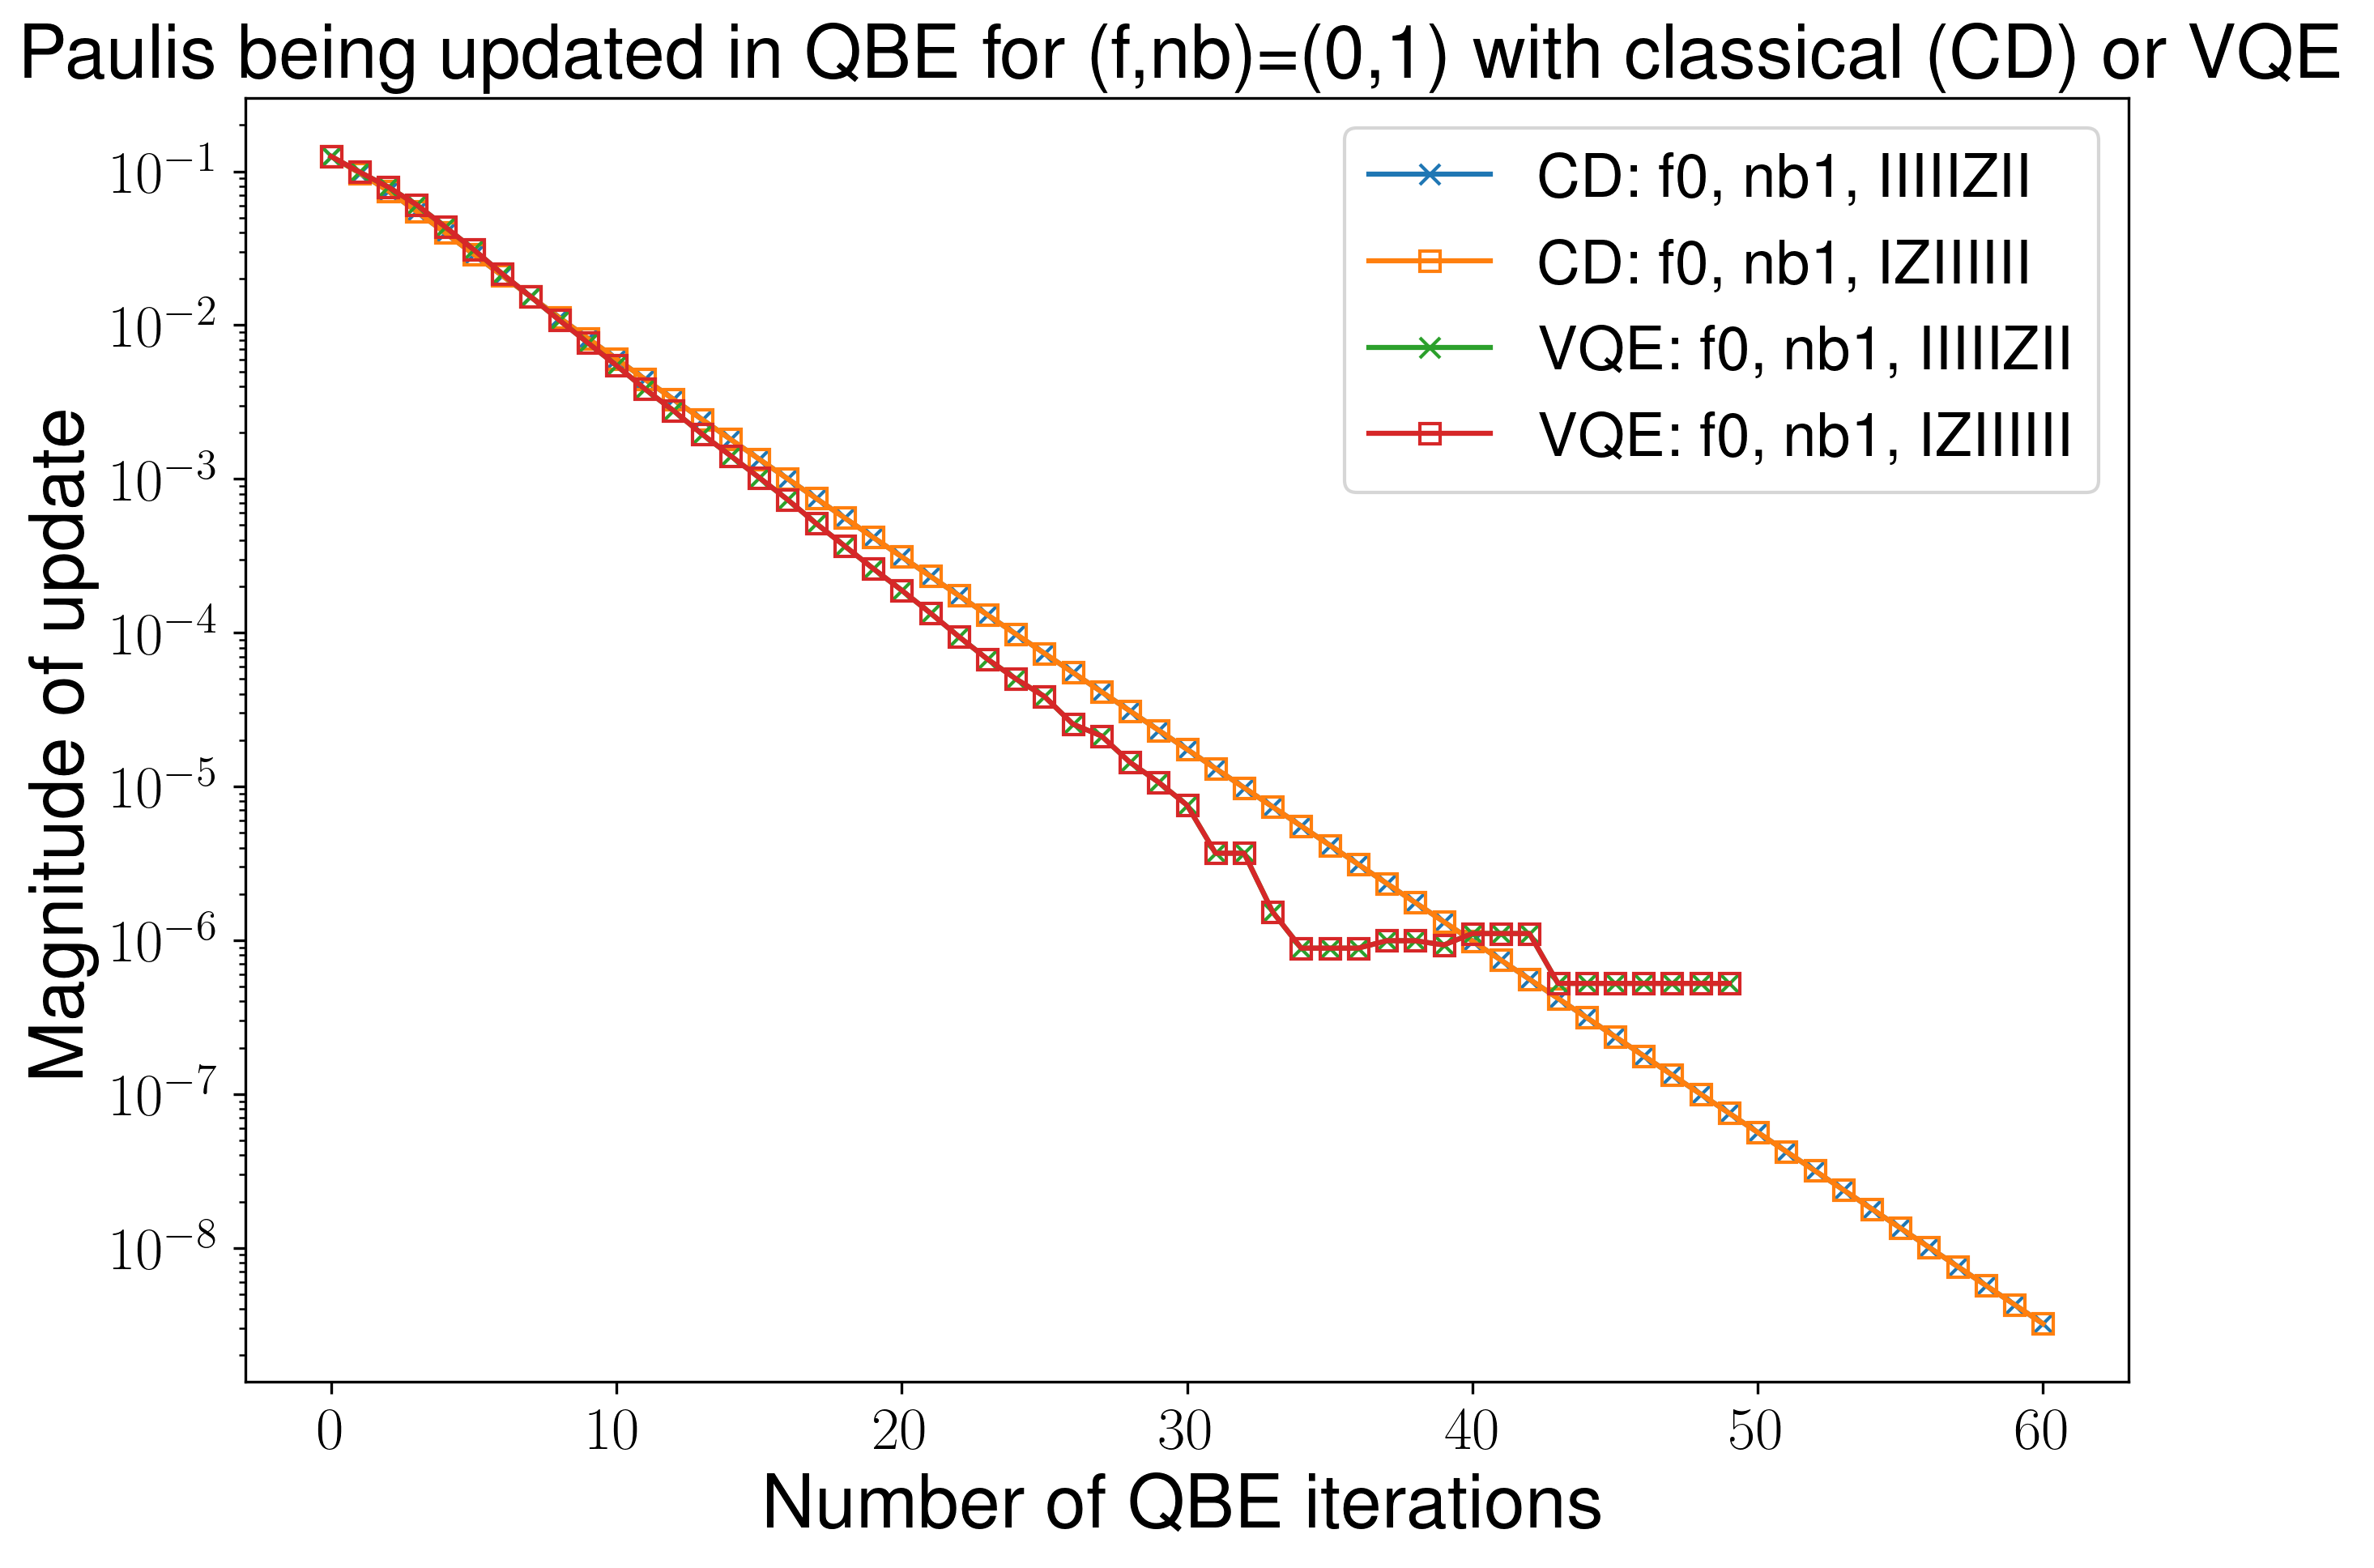

In [48]:
# Updates for different Paulis
plt_fig = plt.figure(figsize=(10,7), dpi=150)
plt.plot(range(61), np.abs(pauli_update_f0nb1_Z1_class), '-x', mfc='none', label='CD: f0, nb1, '+ds_classical_lin['updated_paulis']['0']['1'][0][0][0])
plt.plot(range(61), np.abs(pauli_update_f0nb1_Z2_class), '-s', mfc='none', label='CD: f0, nb1, '+ds_classical_lin['updated_paulis']['0']['1'][0][1][0])

# plt.plot(range(61), np.abs(pauli_update_f1nb0_Z1_class), '-x', mfc='none', label='CD: f1, nb0, '+ds_classical_lin['updated_paulis']['1']['0'][0][0][0])
# plt.plot(range(61), np.abs(pauli_update_f1nb0_Z2_class), '-s', mfc='none', label='CD: f1, nb0, '+ds_classical_lin['updated_paulis']['1']['0'][0][1][0])
#plt.xlabel('iteration number (biggest loop)')

plt.plot(range(50), np.abs(pauli_update_f0nb1_Z1_vqe), '-x', mfc='none', label='VQE: f0, nb1, '+ds_vqe['updated_paulis']['0']['1'][0][0][0])
plt.plot(range(50), np.abs(pauli_update_f0nb1_Z2_vqe), '-s', mfc='none', label='VQE: f0, nb1, '+ds_vqe['updated_paulis']['0']['1'][0][1][0])

# plt.plot(range(50), np.abs(pauli_update_f1nb0_Z1_vqe), '-x', mfc='none', label='VQE: f1, nb0, '+ds_vqe['updated_paulis']['1']['0'][0][0][0])
# plt.plot(range(50), np.abs(pauli_update_f1nb0_Z2_vqe), '-s', mfc='none', label='VQE: f1, nb0, '+ds_vqe['updated_paulis']['1']['0'][0][1][0])

plt.yscale('log')
plt.xlabel('Number of QBE iterations')
plt.ylabel('Magnitude of update')
plt.title('Paulis being updated in QBE for (f,nb)=(0,1) with classical (CD) or VQE')
plt.legend(loc='best')

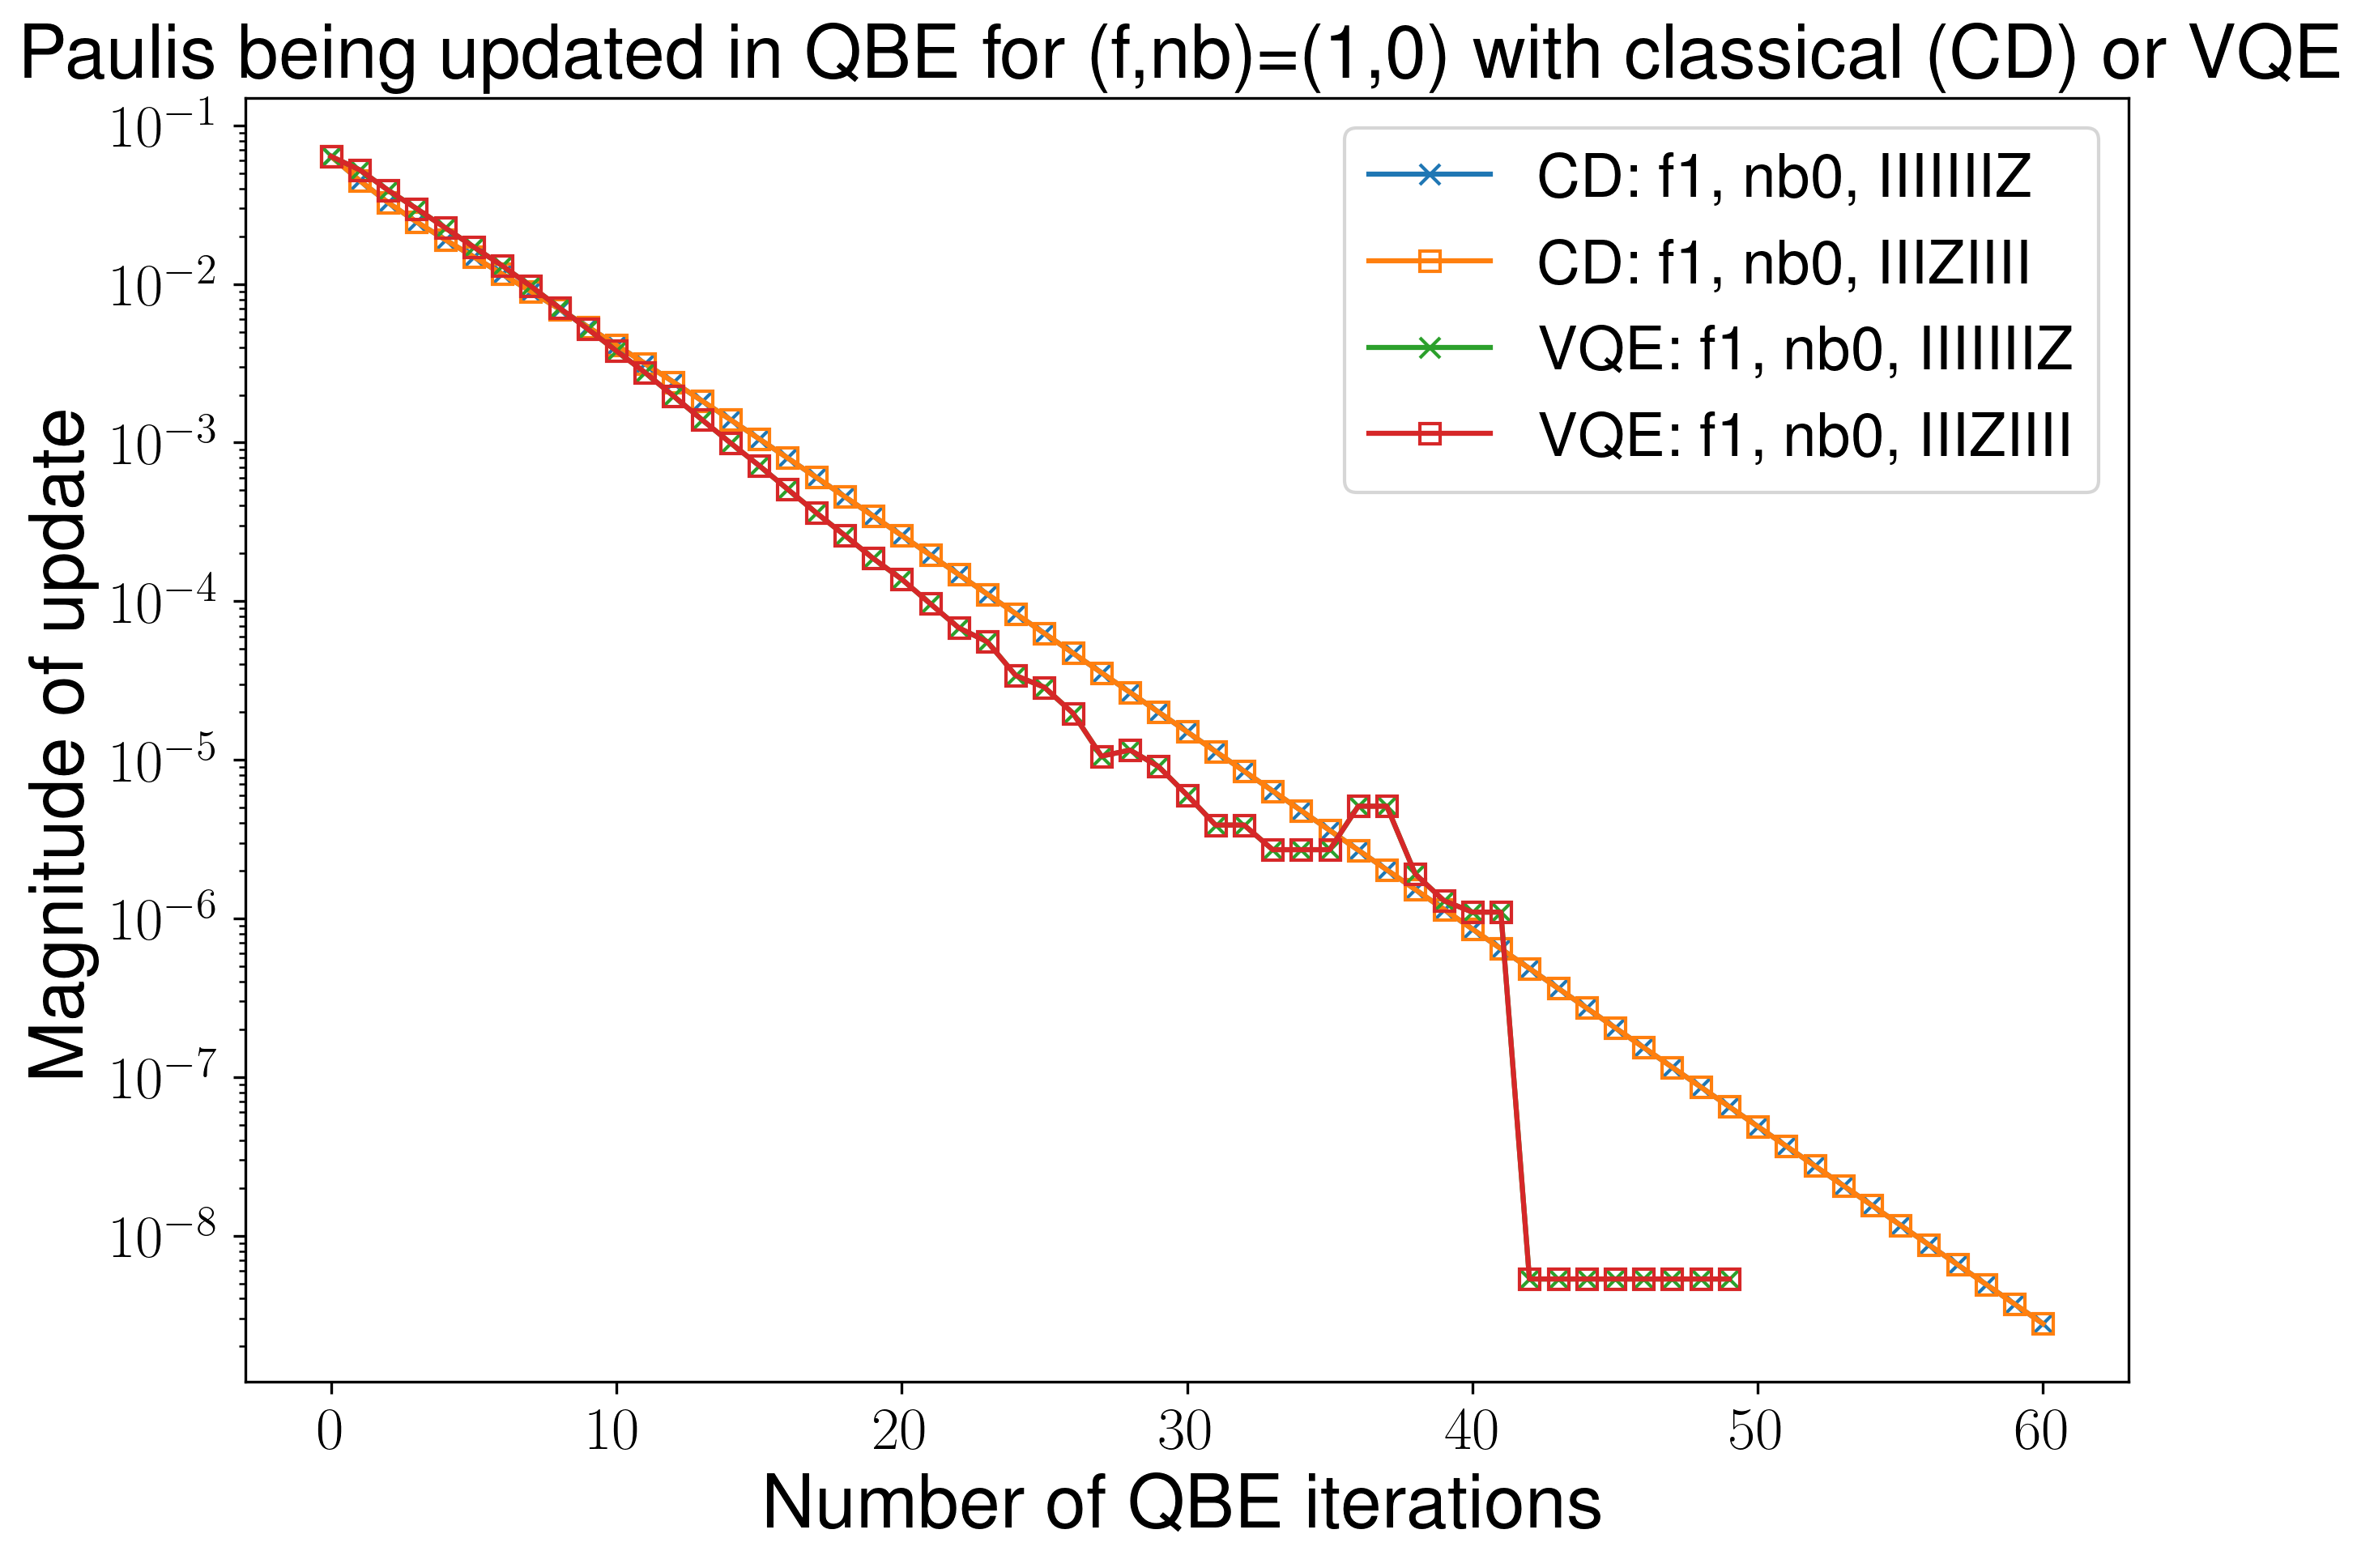

In [49]:
plt_fig = plt.figure(figsize=(10,7), dpi=150)
# plt.plot(range(61), np.abs(pauli_update_f0nb1_Z1_class), '-x', mfc='none', label='CD: f0, nb1, '+ds_classical_lin['updated_paulis']['0']['1'][0][0][0])
# plt.plot(range(61), np.abs(pauli_update_f0nb1_Z2_class), '-s', mfc='none', label='CD: f0, nb1, '+ds_classical_lin['updated_paulis']['0']['1'][0][1][0])

plt.plot(range(61), np.abs(pauli_update_f1nb0_Z1_class), '-x', mfc='none', label='CD: f1, nb0, '+ds_classical_lin['updated_paulis']['1']['0'][0][0][0])
plt.plot(range(61), np.abs(pauli_update_f1nb0_Z2_class), '-s', mfc='none', label='CD: f1, nb0, '+ds_classical_lin['updated_paulis']['1']['0'][0][1][0])
#plt.xlabel('iteration number (biggest loop)')

# plt.plot(range(50), np.abs(pauli_update_f0nb1_Z1_vqe), '-x', mfc='none', label='VQE: f0, nb1, '+ds_vqe['updated_paulis']['0']['1'][0][0][0])
# plt.plot(range(50), np.abs(pauli_update_f0nb1_Z2_vqe), '-s', mfc='none', label='VQE: f0, nb1, '+ds_vqe['updated_paulis']['0']['1'][0][1][0])

plt.plot(range(50), np.abs(pauli_update_f1nb0_Z1_vqe), '-x', mfc='none', label='VQE: f1, nb0, '+ds_vqe['updated_paulis']['1']['0'][0][0][0])
plt.plot(range(50), np.abs(pauli_update_f1nb0_Z2_vqe), '-s', mfc='none', label='VQE: f1, nb0, '+ds_vqe['updated_paulis']['1']['0'][0][1][0])

plt.yscale('log')
plt.xlabel('Number of QBE iterations')
plt.ylabel('Magnitude of update')
plt.title('Paulis being updated in QBE for (f,nb)=(1,0) with classical (CD) or VQE')
plt.legend(loc='best')

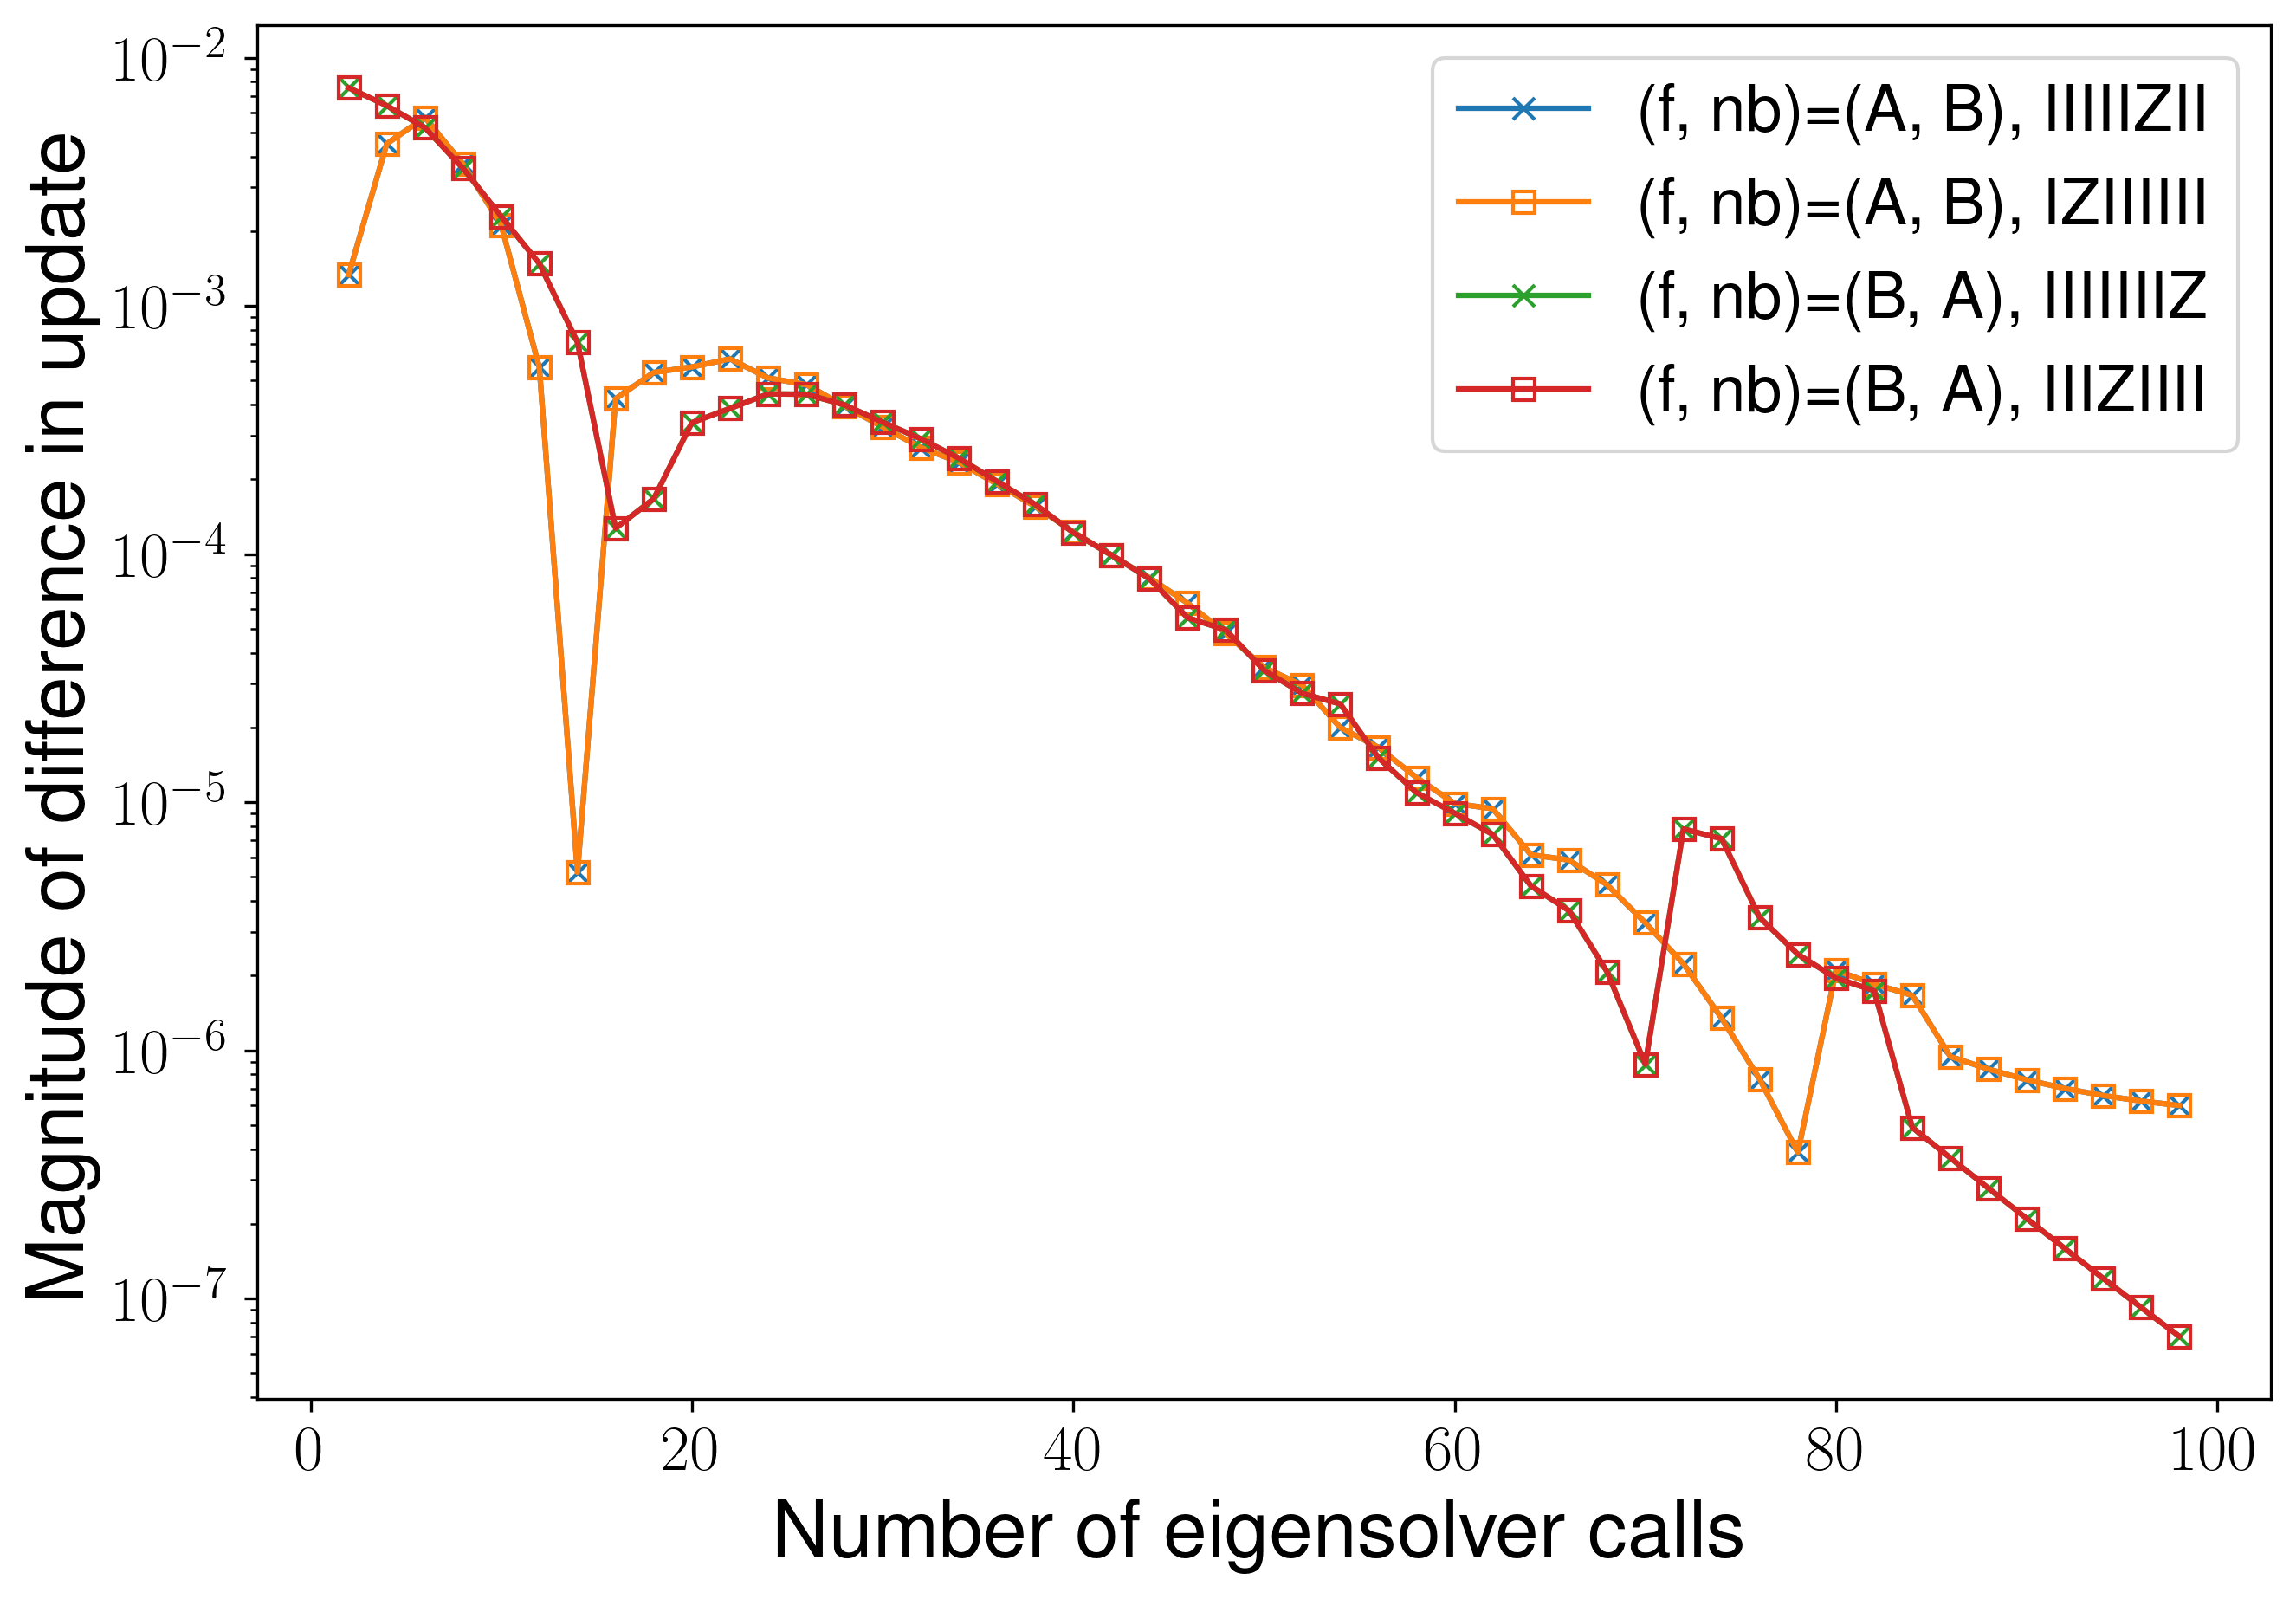

In [67]:
# Difference in gradients 
diff_f0nb1_Z1 = np.abs(np.array(pauli_update_f0nb1_Z1_vqe) - np.array(pauli_update_f0nb1_Z1_class[:50]))
diff_f0nb1_Z2 = np.abs(np.array(pauli_update_f0nb1_Z2_vqe) - np.array(pauli_update_f0nb1_Z2_class[:50]))

diff_f1nb0_Z1 = np.abs(np.array(pauli_update_f1nb0_Z1_vqe) - np.array(pauli_update_f1nb0_Z1_class[:50]))
diff_f1nb0_Z2 = np.abs(np.array(pauli_update_f1nb0_Z2_vqe) - np.array(pauli_update_f1nb0_Z2_class[:50]))

plt_fig = plt.figure(figsize=(10,7), dpi=150)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

# 2* as number of eigensolver calls is 2 times the number of QBE iterations here
plt.plot(2*np.array(range(50))[1:], np.abs(diff_f0nb1_Z1)[1:], '-x', mfc='none', label='(f, nb)=(A, B), '+ds_vqe['updated_paulis']['0']['1'][0][0][0])
plt.plot(2*np.array(range(50))[1:], np.abs(diff_f0nb1_Z2)[1:], '-s', mfc='none', label='(f, nb)=(A, B), '+ds_vqe['updated_paulis']['0']['1'][0][1][0])

plt.plot(2*np.array(range(50))[1:], np.abs(diff_f1nb0_Z1)[1:], '-x', mfc='none', label='(f, nb)=(B, A), '+ds_vqe['updated_paulis']['1']['0'][0][0][0])
plt.plot(2*np.array(range(50))[1:], np.abs(diff_f1nb0_Z2)[1:], '-s', mfc='none', label='(f, nb)=(B, A), '+ds_vqe['updated_paulis']['1']['0'][0][1][0])

plt.yscale('log')
#plt.xlabel('Number of QBE iterations')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('Magnitude of difference in update')
#plt.title('Difference in Pauli updates in QBE between CD and VQE')
plt.legend(loc='best')

plt.savefig('H4_comparison_pauli_updates_classical_vqe_LO2MO_v2.png', bbox_inches='tight', dpi=200)
plt.show()

<Figure size 1500x1050 with 0 Axes>

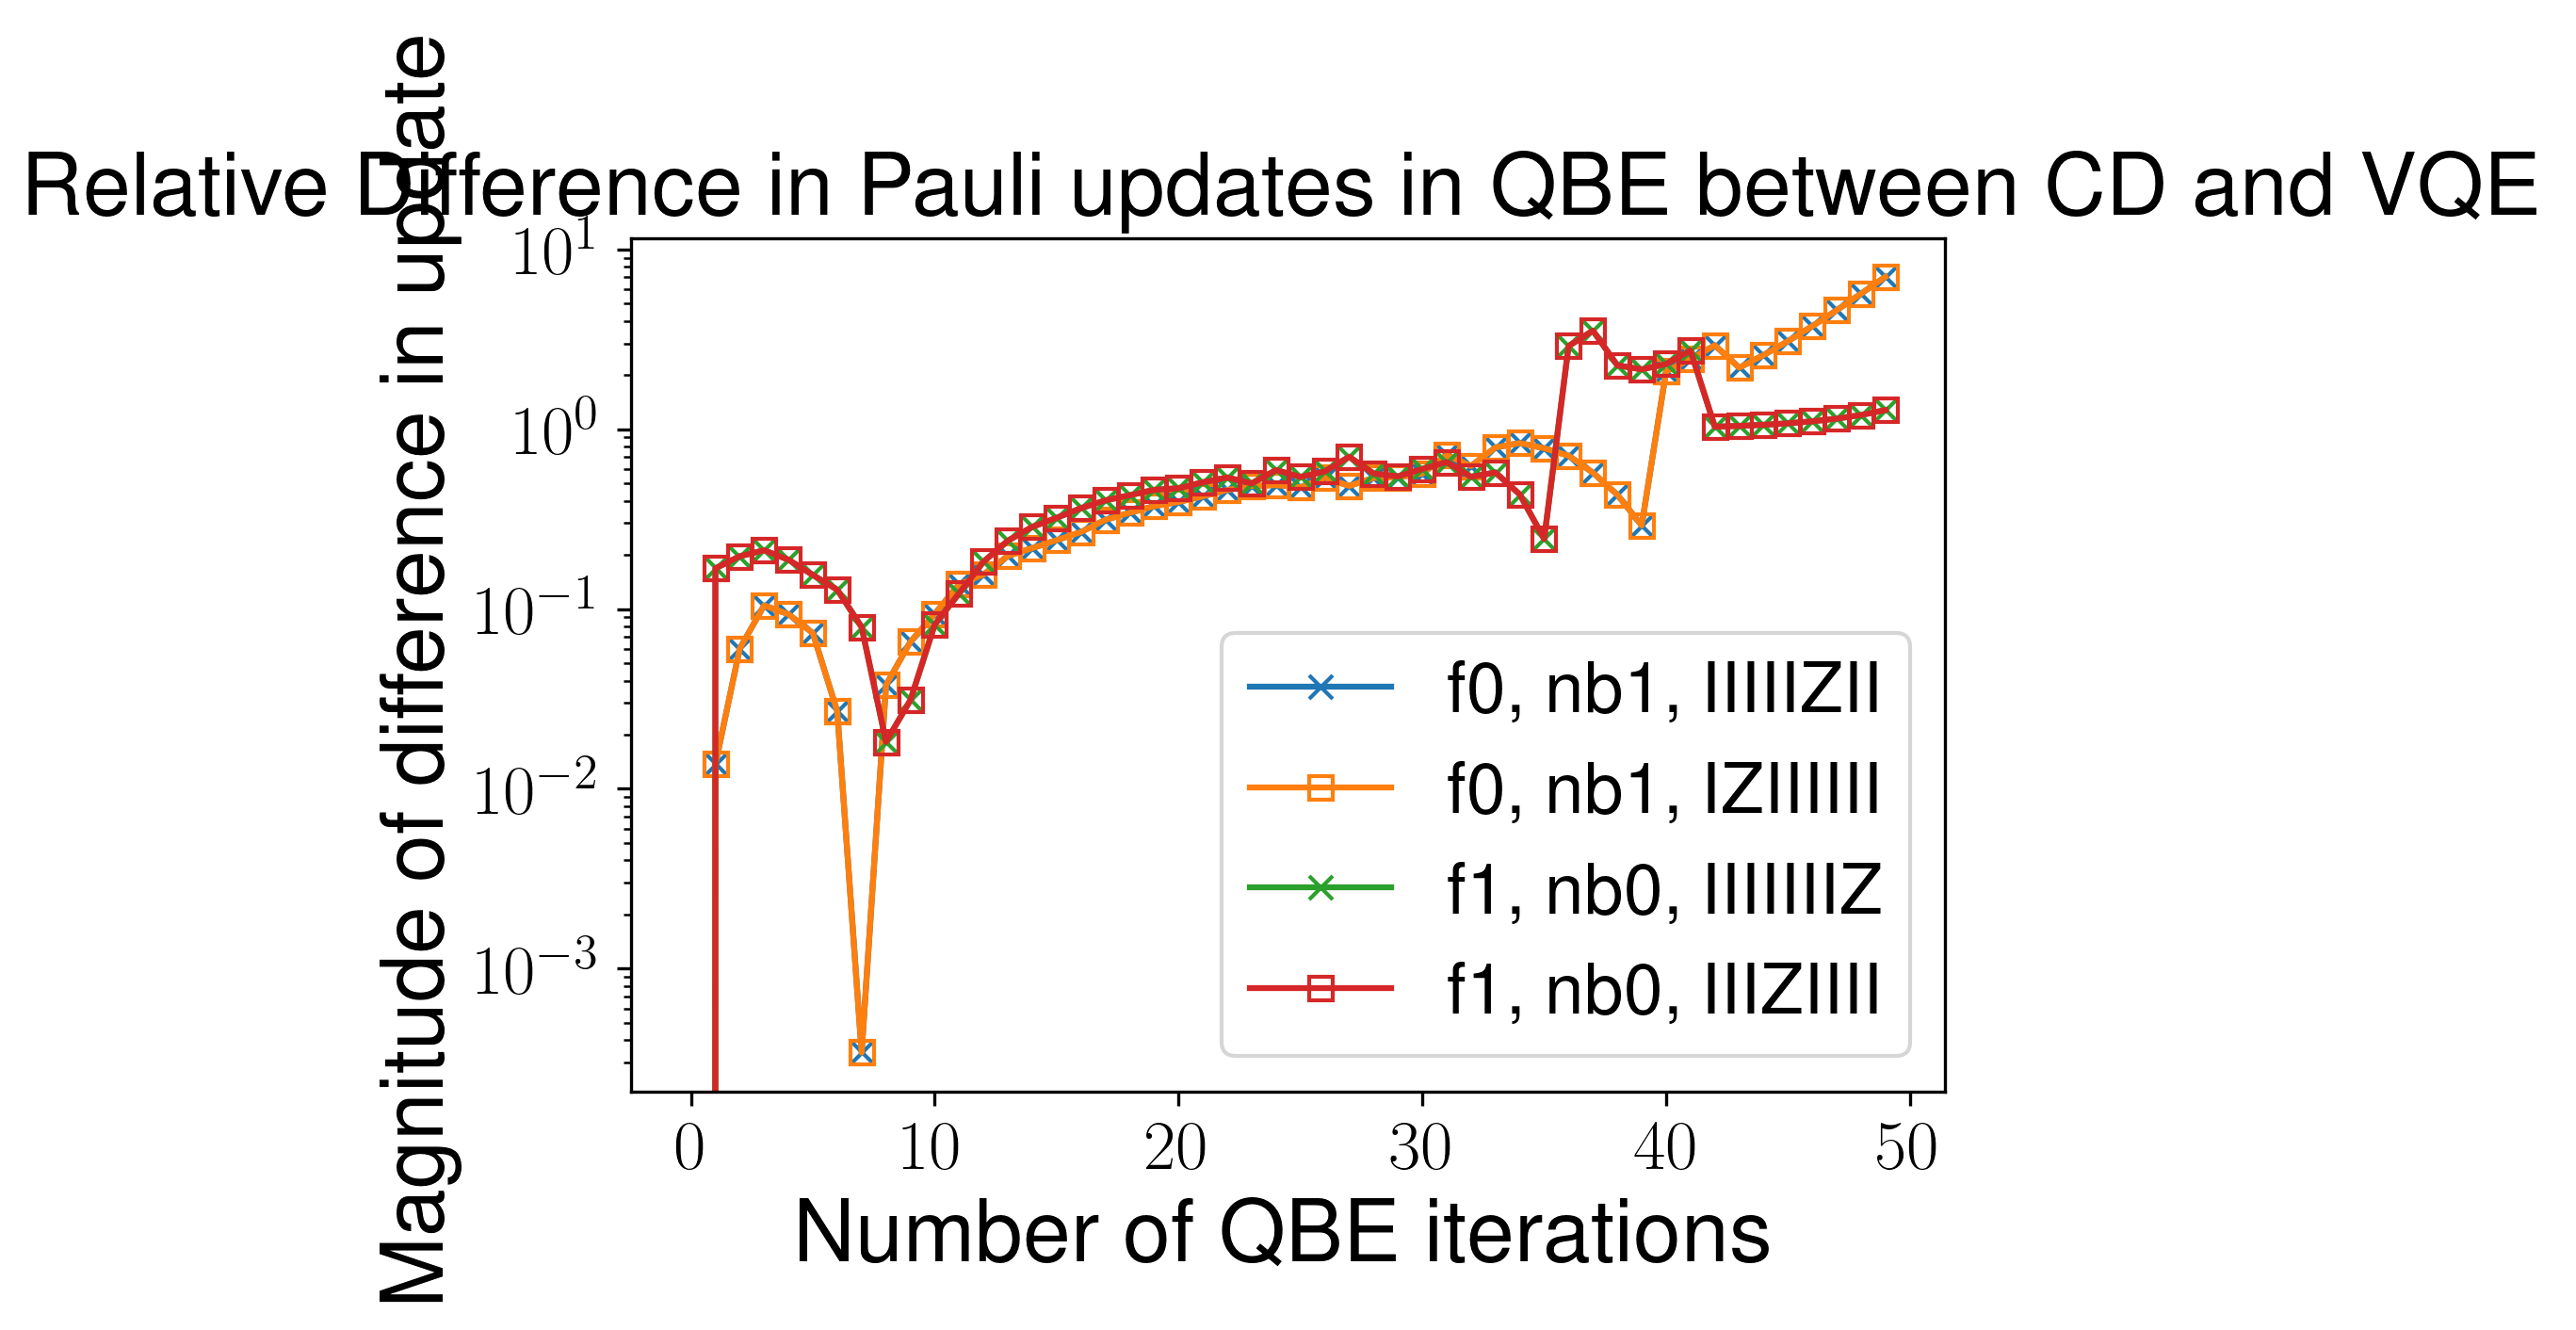

In [55]:
# Relative differences in updated paulis
plt_fig = plt.figure(figsize=(10,7), dpi=150)
rel_diff_f0nb1_Z1 = diff_f0nb1_Z1/np.abs(np.array(pauli_update_f0nb1_Z1_class[:50]) + 1e-8)
rel_diff_f0nb1_Z2 = diff_f0nb1_Z2/np.abs(np.array(pauli_update_f0nb1_Z2_class[:50]) + 1e-8)

rel_diff_f1nb0_Z1 = diff_f1nb0_Z1/np.abs(np.array(pauli_update_f1nb0_Z1_class[:50]) + 1e-8)
rel_diff_f1nb0_Z2 = diff_f1nb0_Z2/np.abs(np.array(pauli_update_f1nb0_Z2_class[:50]) + 1e-8)

plt.figure(dpi = 150)
plt.plot(range(50), np.abs(rel_diff_f0nb1_Z1), '-x', mfc='none', label='f0, nb1, '+ds_vqe['updated_paulis']['0']['1'][0][0][0])
plt.plot(range(50), np.abs(rel_diff_f0nb1_Z2), '-s', mfc='none', label='f0, nb1, '+ds_vqe['updated_paulis']['0']['1'][0][1][0])

plt.plot(range(50), np.abs(rel_diff_f1nb0_Z1), '-x', mfc='none', label='f1, nb0, '+ds_vqe['updated_paulis']['1']['0'][0][0][0])
plt.plot(range(50), np.abs(rel_diff_f1nb0_Z2), '-s', mfc='none', label='f1, nb0, '+ds_vqe['updated_paulis']['1']['0'][0][1][0])

plt.yscale('log')
plt.xlabel('Number of QBE iterations')
plt.ylabel('Magnitude of difference in update')
plt.title('Relative Difference in Pauli updates in QBE between CD and VQE')
plt.legend(loc='best')

plt.savefig('rel_pauli_updates_rmse_classical_vqe_H4_LO2MO_v1.png', bbox_inches='tight')
plt.show()

In [23]:
n_iter_vqe = ds_vqe['iterations']
norm_gradients_vqe = ds_vqe['norm_gradients']
rmse_error_vqe = ds_vqe['rmse_error_fragment_rho']
n_eig_calls_vqe = ds_vqe['n_eig_calls']

In [25]:
rmse_error_vqe[-1]

0.006243662278635404

## Creation of textfile for paper

In [28]:
file = open('vqe_H4_paulisumop_solver_LO2MO', 'rb')

data_H4 = pickle.load(file)
ds_classical_lin, ds_vqe, dict_info_init, dict_info_lin_classical, dict_info_lin_vqe = data_H4

file.close()

/var/folders/z7/960_kj0n3fg8pz04mn8cyp_40000gn/T/ipykernel_6132/270890900.py:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data_H4 = pickle.load(file)


In [29]:
n_iter_vqe = ds_vqe['iterations']
norm_gradients_vqe = ds_vqe['norm_gradients']
rmse_error_vqe = ds_vqe['rmse_error_fragment_rho']
n_eig_calls_vqe = ds_vqe['n_eig_calls']

In [61]:
n_iter_vqe

50

In [33]:
n_iter_class = ds_classical_lin['iterations']
norm_gradients_class = ds_classical_lin['norm_gradients']
rmse_error_class = ds_classical_lin['rmse_error_fragment_rho']
n_eig_calls_class = ds_classical_lin['n_eig_calls']

In [32]:
# Update RMSE and log results
log_filename = "log_H4_paulisumsolver_LO2MO.txt"
f_log = open(log_filename, "a+")

f_log.write("n_iter n_eig_vals norm_gradient rmse_error \n")
for i_iter in range(n_iter_vqe):
    f_log.write("%d %d %3.18f %3.18f \n" % (i_iter, n_eig_calls_vqe[i_iter],
                                            norm_gradients_vqe[i_iter], rmse_error_vqe[i_iter]))

f_log.close()

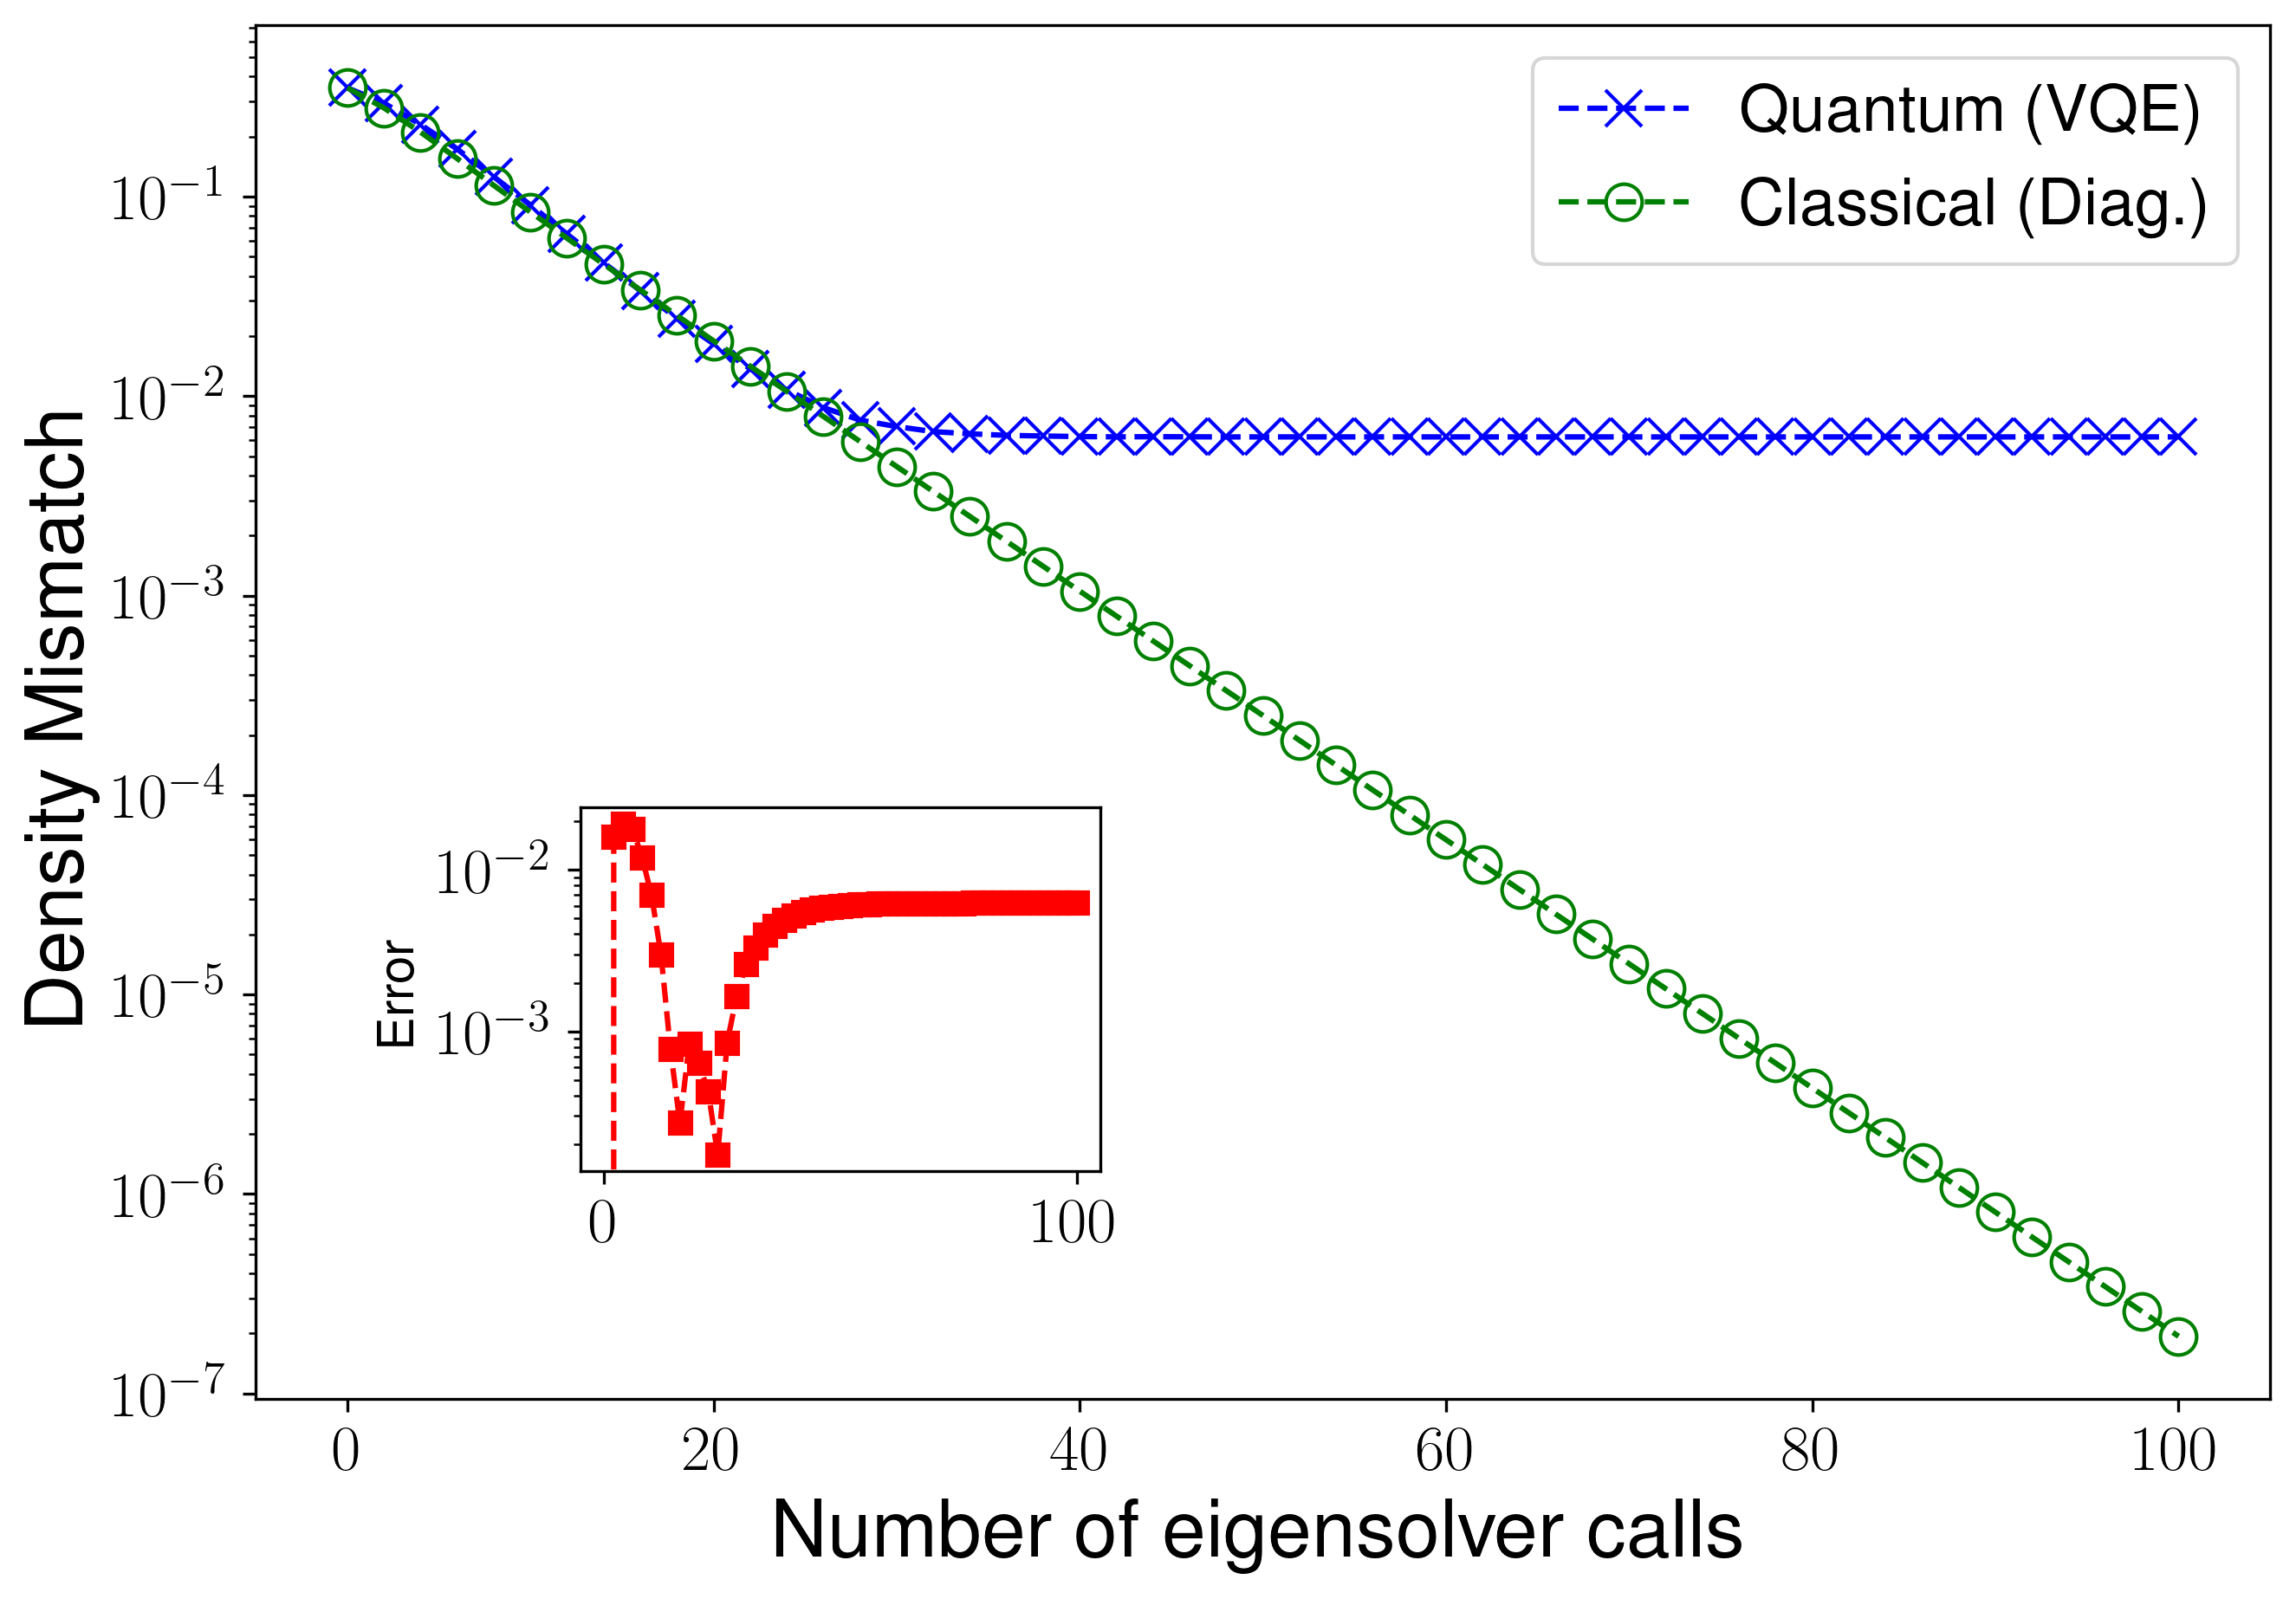

In [40]:
plt_fig = plt.figure(figsize=(10,7), dpi=150)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.plot(n_eig_calls_vqe, rmse_error_vqe, '--x', c='b', ms=10, mfc='None', label='Quantum (VQE)')
plt.semilogy(n_eig_calls_class[:51], rmse_error_class[:51], '--o', ms=10,
             mfc='None',c='g', label='Classical (Diag.)')

plt.yscale('log')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('Density Mismatch')
plt.legend(loc='upper right')

# Inset of errors
left, bottom, width, height = [0.25, 0.25, 0.2, 0.2]
ax2 = plt_fig.add_axes([left, bottom, width, height])

ax2.semilogy(n_eig_calls_vqe, np.abs(np.array(rmse_error_vqe)-np.array(rmse_error_class[:51])), '--s', c='red')
ax2.set_ylabel('Error', fontsize=14)

plt.savefig('comparison_rmse_classical_vqe_H4_LO2MO_v1.png', bbox_inches='tight')
plt.show()